In [1]:
import matplotlib.pyplot as plt
import numpy as np
from constants import SIMULATION_MAGNETON,MASS_LITHIUM_7,BOLTZMANN_CONSTANT
from helper_tools import *

from storage_ring_modeler import StorageRingModel,make_optimal_solution_model
from particle_tracer_lattice import ParticleTracerLattice

from field_generators import HalbachLens,HalbachBender,Collection,Cuboid,Layer,apply_demag,SI_MagnetizationToMagpy,METER_TO_MM,WedgeHalbachLens
from magpylib.current import Line
import time
from scipy.spatial.transform import Rotation as Rot
import random
from swarm_tracer import SwarmTracer
from particle import Particle,Swarm
def simulation_energy_to_mk(E):
    return 1e3*E*MASS_LITHIUM_7/BOLTZMANN_CONSTANT
import copy
from analysis.collectorSimulationHelperFunctions import build_collector_lattice

In [3]:
say_done()

In [2]:
lens=WedgeHalbachLens(.05,.2,.05,'N52')
np.random.seed(42)
coords=np.random.random((1000,3))*.05
np.mean(lens.B_norm(coords)),np.std(lens.B_norm(coords)) #(0.8365572332613057, 0.46422051614363674)

(0.8365572332613057, 0.46422051614363674)

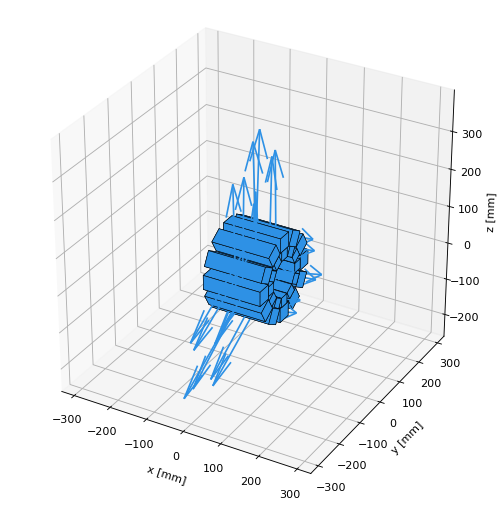

In [191]:
rp=.05
width=.0254
np.random.seed(42)
lens=HalbachLens((rp,rp+width),(width,width*1.5),.1524,'N40',use_standard_mag_errors=True)
R=Rot.from_rotvec([0,np.pi/2,0])
lens.rotate(R)
lens.show()

In [192]:
x=0
def B_vec(y,z):
    q=np.array([x,y,z])
    bx,by,bz=lens.B_vec(q)
    r=np.sqrt(y**2+z**2)
    Br=(by*y + bz*z)/r
    B_theta=(-z*by + y*bz)/r
    return Br,B_theta
def B_norm(y,z):
    q=np.array([x,y,z])
    return lens.B_norm(q)

looping over function inputs to make image data


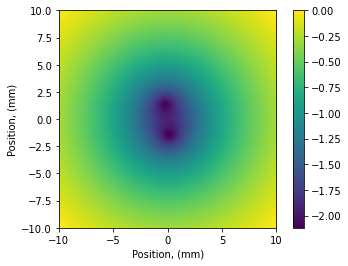

In [206]:
x_vals=np.linspace(-.01,.01,100)
image,extent=make_image_cartesian(B_norm,x_vals,x_vals)
image=image/np.max(image)
extent=np.array(extent)*1e3
plt.imshow(np.log10(image),extent=extent)#,cmap='Reds')
plt.xlabel("Position, (mm)")
plt.ylabel("Position, (mm)")
plt.colorbar()
plt.savefig("thesis0",dpi=300)
plt.show()
# plt.contour([x_vals,x_vals],image)

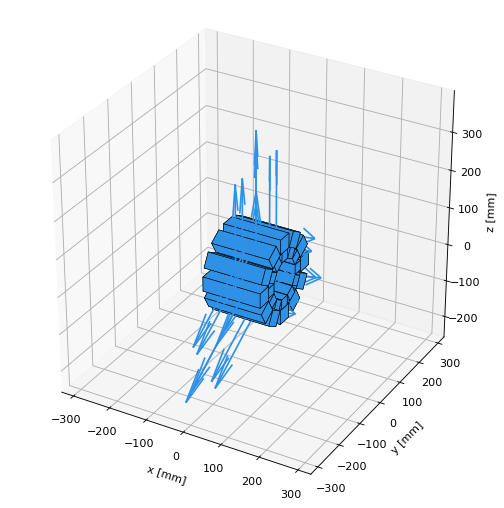

In [157]:


theta_vals=np.linspace(0,2*np.pi,300)[:-1]
r0=.03
y_vals,z_vals=np.cos(theta_vals)*r0,np.sin(theta_vals)*r0
Br_vals,B_theta_vals=np.array([B_vec(y,z) for y,z in zip(y_vals,z_vals) ]).T

In [158]:
from math import atan




def B_pole(y,z,n,orientation):
    assert isinstance(n,int)
    theta=np.arctan2(z,y)
    if orientation=='skew':
        return -np.cos(n*theta+np.pi/2),-np.sin(n*theta)
    elif orientation=='upright':
        return np.sin(n*theta),np.cos(n*theta)
    else:
        raise NotImplementedError
def projection(n,orientation):
    Br_vals_pole,B_theta_vals_pole=np.array([B_pole(y,z,n,orientation) for y,z in zip(y_vals,z_vals) ]).T
    overlap=Br_vals_pole*Br_vals
    return np.trapz(overlap,theta_vals)
def pole_amplitude(n):
    amp1=projection(n,'skew')
    amp2=projection(n,'upright')
    return np.sqrt(amp1**2+amp2**2)


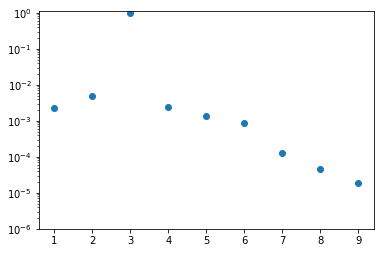

In [156]:
n_vals=list(range(1,10))
amps_err2=np.array([pole_amplitude(n) for n in n_vals])
amps_err2/=np.max(amps_err2)
plt.semilogy(n_vals,amps_err2,linewidth=0,marker='o')
plt.ylim([1e-6,1.1])
plt.show()

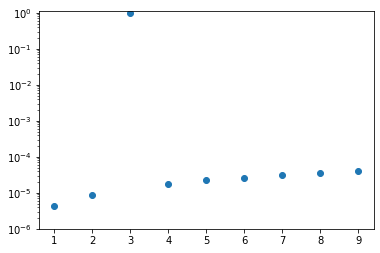

In [159]:
n_vals=list(range(1,10))
amps_ideal2=np.array([pole_amplitude(n) for n in n_vals])
amps_ideal2/=np.max(amps_ideal2)
plt.semilogy(n_vals,amps_ideal2,linewidth=0,marker='o')
plt.ylim([1e-6,1.1])
plt.show()

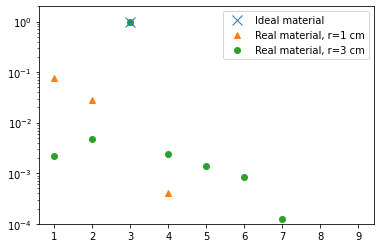

In [219]:
plt.semilogy(n_vals,amps_ideal1,linewidth=0,marker='x',label='Ideal material',zorder=10,markersize=10)
plt.semilogy(n_vals,amps_err1,linewidth=0,marker='^',label='Real material, r=1 cm')
plt.semilogy(n_vals,amps_err2,linewidth=0,marker='o',label='Real material, r=3 cm')
plt.ylim([1e-4,2])
# plt.axvline(x=3,c='r',linestyle=':')
plt.legend()
plt.savefig("thesis1",dpi=300)
plt.show()

In [ ]:
from matrix_method_tracing import transfer_matrix_func_from_lens,K_mag_vals_and_slice_lengths_from_lens_el
el=lattice[1]
M=transfer_matrix_func_from_lens(el)

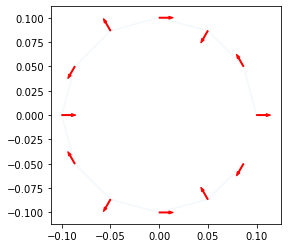

In [37]:
r_pos=.1
r_arrow=.01
num=12
phi_vals=np.linspace(0,2*np.pi,num+1)[:-1]
theta_vals=phi_vals*(3+1)
for phi,theta in zip(phi_vals,theta_vals):
    x=r_pos*np.cos(phi)
    y=r_pos*np.sin(phi)
    dx=r_arrow*np.cos(theta)
    dy=r_arrow*np.sin(theta)
    plt.arrow(x,y,dx,dy,color='r')
    # plt.scatter(x,y)
x_vals,y_vals=r_pos*np.cos(phi_vals),r_pos*np.sin(phi_vals)
plt.plot(x_vals,y_vals,alpha=.05)
plt.gca().set_aspect('equal')
plt.savefig('thesis',dpi=300)

In [36]:
rp=.05
lens=HalbachLens(rp,.0254,.5,'N52')
R=Rot.from_rotvec([0,0,np.pi])
lens.rotate(R)
def wrap(x,y):
    r=np.sqrt(x**2+y**2)
    if r>=rp-1e-6:
        return np.nan
    else:
        return lens.B_norm(np.array([x,y,0]))
x_vals=np.linspace(-rp,rp,300)
image,_=make_image_cartesian(wrap,x_vals,x_vals)

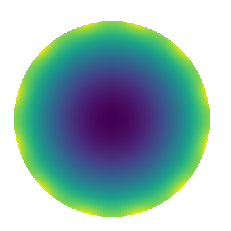

In [37]:
plt.imshow(image)
plt.xlim([-10,320])
plt.ylim([-10,320])
plt.gca().axis('off')
plt.savefig('thesis',dpi=300)
plt.show()

In [3]:
def norm(x,y):
    return col.B_norm(np.array([x,y,0]))
    # return col.B_vec(np.array([x,y,0]))[1]
x_vals=np.linspace(-r1,r1)/2
image,exten=make_image_cartesian(norm,x_vals,x_vals)
plt.imshow(image)
plt.show()
y_vals=[norm(x,0) for x in x_vals]
plt.plot(x_vals,y_vals)

NameError: name 'r1' is not defined

In [27]:
q_vals=np.random.random((50_000,3))
t=time.time()
col.B_norm(q_vals)
time.time()-t

10.880269050598145

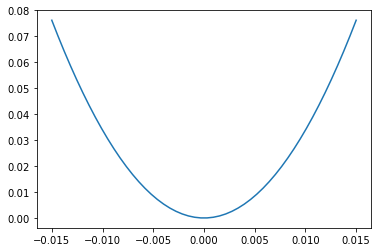

In [26]:
lens=HalbachLens(.05,.025,1.0,'N52')
def norm(x,y):
    # return col.B_norm(np.array([x,y,0]))
    return lens.B_norm(np.array([x,y,0]))
x_vals=np.linspace(-.03,.03)/2
# image,exten=make_image_cartesian(norm,x_vals,x_vals)
# plt.imshow(image)

y_vals=[norm(x,0) for x in x_vals]
plt.plot(x_vals,y_vals)

In [19]:
from analysis.phaseSpaceAnalyzer import SwarmPoincare
def energy_snap(swarm,x_snap):
    try: #because of the annoying issue with no orbit coords in the combiner!
        swarm_snap=SwarmPoincare(swarm,x_snap)
    except:
        swarm_snap=SwarmPoincare(swarm,x_snap-.4)
    E_vals=[]
    for particle in swarm_snap.get_Surviving_Particles():
        deltaE=simulation_energy_to_mk(particle.deltaE)
        E_vals.append(deltaE)
    return np.mean(E_vals),np.std(E_vals)
def energies_of_swarm(swarm):
    x_max=max([particle.qo_vals[-1,0] for particle in swarm])
    x_max*=.95
    revs=int(max(particle.revolutions for particle in swarm))
    num_points=min([100,revs])
    x_vals=np.linspace(.5,x_max,num_points)
    energies=np.array([energy_snap(swarm,x) for x in x_vals])
    E_mean,E_std=energies.T
    return x_vals,E_mean,E_std
def energies(h,T,use_long_range_fields):
    swarm=trace_swarm(h,T,use_long_range_fields)
    return energies_of_swarm(swarm)

In [ ]:
T0=30.0
cross_talk=True
wrap=lambda x: energies(*x)
args=[(1e-5,T0,cross_talk),(5e-6,T0,cross_talk),(2e-6,T0,cross_talk),(1e-6,T0,cross_talk)]
# args=[(1e-5,T0,True),(5e-6,T0,True),(2e-6,T0,True),(1e-6,T0,True)]
results=[wrap(arg) for arg in args]

In [ ]:
idx=3
T=args[idx][0]
x_vals,E_mean,E_std=results[idx]
T_vals=x_vals/210.0
plt.title("Cross talk enabled, "+str(T)+" second time step")
plt.plot(T_vals,E_mean,label='mean value')
plt.fill_between(T_vals,E_mean+E_std,E_mean-E_std,alpha=.5,label='STD')
plt.xlabel('Simulation time, (s)')
plt.ylabel("Energy change, mk")
plt.legend()
plt.show()

In [ ]:
import sympy as sym
b,c,x=sym.symbols('b c x')
f=b*sym.cos(3*x)**2+c*sym.sin(3*x)**2
sym.trigsimp(f)

In [ ]:
swarm_traced.survival_bool()

In [ ]:
SIMULATION_MAGNETON/BOLTZMANN_CONSTANT

In [ ]:
pt=model.swarm_tracer_ring.particle_tracer
swarm=model.swarm_tracer_ring.initalize_pseudorandom_swarm_in_phase_space(1e-3,3.0,3.0,100,same_seed=True)
swarm_traced=model.swarm_tracer_ring.trace_swarm_through_lattice(swarm,1e-6,30.0,parallel=True,use_fast_mode=True)
def get_energy(q,p):
    el=pt.which_element_lab_coords(q)
    KE=np.linalg.norm(p)**2/2
    V=el.magnetic_potential(el.transform_lab_coords_into_element_frame(q))
    return KE+V
def initial_energy(particle):
    q,p=particle.qi,particle.pi
    return get_energy(q,p)
def final_energy(particle):
    q,p=particle.qf,particle.pf
    return get_energy(q,p)
def energy_change(particle):
    Ei,Ef=initial_energy(particle),final_energy(particle)
    return Ef-Ei

In [ ]:
dE=[energy_change(particle) for particle in swarm_traced]
plt.hist(dE)
print(np.mean(dE),np.std(dE),np.min(dE),np.max(dE))

In [ ]:
%matplotlib inline
# %matplotlib tk
pole=6
thetas=np.arange(0,pole)*2*np.pi/pole #+np.pi/6
r=.04
hex=Collection()
L=10*r
I=-100
for theta in thetas:
    x,y=r*np.cos(theta)*1e3,r*np.sin(theta)*1e3
    line=Line(vertices=((x,y,-L*1e3),(x,y,L*1e3)),current=I)
    I*=-1
    hex.add(line)
# line.show()
hex.show()

In [ ]:
def B_norm(x,y):
    return hex.B_norm(np.array([x,y,0.0]))
x_vals=np.linspace(-r,r)*.1
image_coil,_=make_image_cartesian(B_norm,x_vals,x_vals)
plt.imshow(image_coil)
plt.colorbar()
plt.show()

In [ ]:
%matplotlib inline
slices=round(L/(2*(r/2)))
lens=HalbachLens(r,r/2,L,'N52',num_disks=slices)
def B_norm(x,y):
    return lens.B_norm(np.array([x,y,0.0]))
image_lens_exact,_=make_image_cartesian(B_norm,x_vals,x_vals)
plt.imshow(image_lens_exact)
plt.colorbar()
plt.show()

In [ ]:
%matplotlib inline
lens=HalbachLens(r,r/2,.5,'N52',num_disks=slices)
col=Collection(lens.copy())
col.add(hex.copy())
def B_norm(x,y):
    return col.B_norm(np.array([x,y,0.0]))
image_lens_coil_exact,_=make_image_cartesian(B_norm,x_vals,x_vals)
plt.imshow(image_lens_coil_exact)
plt.colorbar()
plt.show()

In [ ]:
%matplotlib inline
lens=HalbachLens((r,r),(r/2,r/2),.5,'N52',use_standard_mag_errors=True,seed=42,num_disks=slices)
# lens=HalbachLens(r,r/2,.5,'N52',use_standard_mag_errors=True,seed=42,num_disks=slices,use_method_of_moments=True)
def B_norm(x,y):
    return lens.B_norm(np.array([x,y,0]))
image_lens_err,_=make_image_cartesian(B_norm,x_vals,x_vals)
plt.imshow(image_lens_err)
plt.colorbar()
plt.show()
# lens.show()

In [ ]:
%matplotlib inline
lens=HalbachLens(r,r/2,.5,'N52',use_standard_mag_errors=True,seed=42,num_disks=slices)
col=Collection(lens.copy())
col.add(hex.copy())
def B_norm(x,y):
    return col.B_norm(np.array([x,y,0.0]))
image_lens_coil_err,_=make_image_cartesian(B_norm,x_vals,x_vals)
plt.imshow(image_lens_coil_err)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(image_lens_err-image_lens_exact)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(image_lens_coil_err-image_lens_coil_exact)
plt.colorbar()
plt.show()

In [ ]:
import sympy as sym
pn,xn=sym.symbols('p_n x_n',real=True)
h,m,w=sym.symbols('h m w',real=True,positive=True)
pndot=-w**2 *m*xn
xn1=xn+pn*h/m# +(h**2/2)*pndot/m
pn1dot=-w**2 *m*xn1
pn1=pn +(pndot+pn1dot)*h/2
display(xn1)
display(pn1)
M=sym.linear_eq_to_matrix([xn1,pn1],[xn,pn])[0]
display(M)


In [ ]:
alpha=sym.symbols('alpha',real=True,positive=True)
lam1,lam2=list(M.eigenvals().keys())
display(sym.simplify(lam1))
display(sym.simplify(lam2))
lam1=sym.simplify(lam1.subs(h,alpha/w))
lam2=sym.simplify(lam2.subs(h,alpha/w))
display(lam1)
display(lam2)


In [ ]:
display(sym.Abs(sym.limit(lam1,alpha,0)))
display(sym.Abs(sym.limit(lam2,alpha,0)))
display(sym.Abs(sym.limit(lam1,alpha,sym.oo)))
display(sym.Abs(sym.limit(lam2,alpha,sym.oo)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
alpha_vals=np.linspace(0,4.0,1000)
lam1_vals=[float(sym.Abs(lam1.subs(alpha,x))) for x in alpha_vals]
lam2_vals=[float(sym.Abs(lam2.subs(alpha,x))) for x in alpha_vals]
plt.plot(alpha_vals,lam1_vals)
plt.plot(alpha_vals,lam2_vals)
plt.show()

In [ ]:
model=make_optimal_solution_model('2',build_field_helpers=False,use_long_range_fields=False,include_mag_errors=False)

In [ ]:
%matplotlib tk
lattice=model.lattice_ring
el=lattice[5]
el.Lm/el.magnet_width

In [ ]:
PTL=ParticleTracerLattice()
PTL.ad

In [ ]:
def solve():
    seed=int(time.time())
    np.random.seed(seed)
    model_cross_talk=make_optimal_solution_model('2',build_field_helpers=False,use_long_range_fields=False,include_mag_errors=False)
    np.random.seed(seed)
    model_no_cross_talk=make_optimal_solution_model('2',build_field_helpers=False,use_long_range_fields=False,include_mag_errors=True)
    return model_cross_talk.mode_match(parallel=True),model_no_cross_talk.mode_match(parallel=True)
result=solve()

In [ ]:
result

In [ ]:
ax,ay,r0,delta=sym.symbols('a_x a_y r_0 delta',positive=True)
f1=r0-delta-ax
f2=sym.sqrt(r0**2-delta**2)-ay
sym.solve((f1,f2),(r0,delta))[0][0]

In [ ]:
import sympy as sym
s,R,P=sym.symbols('s R P',real=True,positive=True)
K=sym.symbols('K',real=True,negative=True)
D0,Dp0=sym.symbols('D_0 D\'_0',real=True)
x=sym.Function('x')(s)
ics={x.subs(s,0):D0,x.diff(s).subs(s,0): Dp0}
func=x.diff(s,2)+x*K-P
x=sym.dsolve(func,func=x,ics=ics).rhs
# display(x.expand())
# sym.trigsimp(display(x.diff(s).expand()))
sym.simplify(sym.simplify(x.expand().rewrite(sym.cos)).subs(K,-K))
# sym.simplify(sym.simplify(x.diff(s).expand().rewrite(sym.cos)))

In [ ]:
sym.simplify(sym.simplify(x.diff(s).expand().rewrite(sym.cos)))

In [ ]:
import sympy as sym
K,s,R=sym.symbols('K s R',real=True,positive=True)
D0,Dp0=sym.symbols('D_0 D\'_0',real=True)
x=sym.Function('x')(s)
ics={x.subs(s,0):D0,x.diff(s).subs(s,0): Dp0}
func=x.diff(s,2)+x*K-2/R
x=sym.dsolve(func,func=x,ics=ics).rhs
display(x.expand())
display(x.diff(s).expand())

In [ ]:
model.mode_match(parallel=True)

In [ ]:
#  description:                     delta E mean,       delta E std,       min delta E,     max delta E
# nominal magnets, 5e-6 step size : -35.24546866443747 90.97553796215479 -395.8918003062099 199.6268382365124
# nominal magnets, 1e-6 step size: -3.0498819593304143 86.47725716894485 -363.760420308161 231.83005723528186
# nominal magnets, 5e-7 step size: 5.7140239209199715 88.82552276464713 -358.1629997353084 243.6865364506266
# twice point density everywhere, 5e-6 step size: -41.46160607240741 55.93358143046129 -212.3540295591847 80.21600315286923
# Change derivative to central from forward, 5e-6 step size: -32.52383801141834 88.80174306204253 -395.9105656453685 200.74092691069018
# double density in len transverse coordinates, 5e-6 step size: -32.000613813870984 81.81744962453821 -280.66042333380756 154.45880935243258
# double density in combiner, 5e-6 step size: -36.851069545712996 97.16351349682155 -398.50996156298424 232.32720046058967
# double density in bender, 5e-6 step size: -32.570700723675216 49.45585831490073 -189.81751567288302 101.81453417169178
# double density in bender longitduinal, 5e-6 step size: -34.473488332671515 89.5214949594357 -384.84784138825125 196.350211209985
#double density in transverse bender, 5e-6: -31.648435972079678 49.031648516128044 -193.51181627203187 85.34604303615197
# double density in horizontal plane of bender, 5e-6: -38.14013223042035 65.56861530012485 -203.1955141510589 145.83996654791554
# bender cross talk only present in generator form, not interp, 5e-6: 5.667390020517887 82.0292247275941 -200.74100571383678 229.78629662913954
#double field falloff cutoff for generators, 5e-6: -36.6327247818515 87.94006894271281 -385.49826421411854 194.94168651146538
#double density in transverse bender, 1e-6: 2.126221332948262 50.9564774743791 -195.00286684164166 122.14332485583873
#double density in transverse bender with max step interp size lens, 1e-6: 8.478547737985863 39.21509134604949 -102.93793821644067 118.33216237340821
#Default magnet settings, 1e-6 step size, magnet errors and cross talk enabled: 11.793900226883999 17.533017905737783 -29.909511328474764 65.93077262899897

In [ ]:
import numpy as np
np.random.randint(2**64)

In [ ]:
swarm=model.swarm_tracer_ring.initalize_pseudorandom_swarm_in_phase_space(1e-3,3.0,3.0,5,same_seed=True)
swarm_traced=model.swarm_tracer_ring.trace_swarm_through_lattice(swarm,5e-6,30.0,parallel=True,use_fast_mode=False)

In [ ]:
%matplotlib inline
swarm_traced[2].plot_energies(show_only_total_energy=True)

In [ ]:
import constants
constants.MAGNET_DIMENSIONAL_TOLERANCE=0.0
constants.MAGNET_MAGNETIZATION_ANGLE_TOLERANCE=0.0
constants.MAGNET_MAGNETIZATION_NORM_TOLERANCE=0.0
t=time.time()
model=make_optimal_solution_model('2',use_bumper=False,include_mag_errors=True,use_long_range_fields=True,build_field_helpers=False)
print(time.time()-t)
t=time.time()
model.build_field_helpers_if_unbuilt(parallel=True)
print(time.time()-t)
t=time.time()
print(model.mode_match(parallel=True))
print(time.time()-t)

In [ ]:
import constants
constants.MAGNET_DIMENSIONAL_TOLERANCE=0.0
constants.MAGNET_MAGNETIZATION_ANGLE_TOLERANCE=0.0
constants.MAGNET_MAGNETIZATION_NORM_TOLERANCE=0.0
t=time.time()
model=make_optimal_solution_model('2',use_bumper=False,include_mag_errors=True,use_long_range_fields=True,build_field_helpers=False)
print(time.time()-t)
t=time.time()
model.build_field_helpers_if_unbuilt(parallel=True)
print(time.time()-t)
t=time.time()
print(model.mode_match(parallel=True))
print(time.time()-t)

In [ ]:
from matrix_method_tracing import Lattice,stability_factors_lattice
import numpy as np
lattice=Lattice()
lattice.add_lens(.1,1.0,.01)
lattice.add_drift(.1)
Mx=lattice.M_total()[0]
Mx


In [ ]:
from particle_tracer_lattice import ParticleTracerLattice
from particle_tracer import ParticleTracer,trace_particle_periodic_linear_lattice
from particle import Particle
import matplotlib.pyplot as plt
PTL=ParticleTracerLattice()
for _ in range(5):
    PTL.add_lens_ideal(.1,1.0,.01)
    PTL.add_drift(.1)
PTL.end_lattice()
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,1e-3,0]))
particle=pt.trace(particle,1e-5,.1)
# particle.plot_orbit_reference_frame_position()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)
# particle=trace_particle_periodic_linear_lattice(particle,pt,1e-5,.005)
# plt.plot(particle.qo_vals[:,1])
# plt.show()

In [ ]:
num_iters=20
tol_max=1e-3
steps=12
tol_min=tol_max/steps
tolerances=np.linspace(tol_min,tol_max,steps)
tolerances=np.repeat(tolerances,num_iters)
tolerances=np.append(tolerances,0.0)
results=parallel_evaluate(solve,tolerances,results_as_arr=True)

In [ ]:
np.savetxt("misalignment_results.txt",results)

In [ ]:
model.mode_match(parallel=True)

In [ ]:
model.mode_match(parallel=True)

In [ ]:
visits=31e6
t=5
people=visits*t/365

100_000*72/people


In [ ]:
"""
15.01213526725769
61.86362600326538
(0.8696893904877981, 331.8094275610885)
85.38829898834229
"""

In [ ]:
swarm=model.swarm_tracer_ring.initalize_pseudorandom_swarm_in_phase_space(1e-3,3.0,1.0,100)
swarm_traced=model.swarm_tracer_ring.trace_swarm_through_lattice(swarm,5e-6,10.0,parallel=True,use_fast_mode=False)

In [ ]:
lens=model.lattice_ring[0]

In [ ]:
for i,el in enumerate(model.lattice_injector):
    print(i)
    el.is_coord_inside(np.array([1,1,1]))

In [ ]:
model.swarm_tracer_injector.lattice[5].is_coord_inside(np.array([1,1,1]))

In [ ]:
t=time.time()
model=make_optimal_solution_model('2',use_bumper=False,build_field_helpers=False,include_mag_errors=False)
print(time.time()-t)
t=time.time()
model.build_field_helpers_if_unbuilt(parallel=True)
print(time.time()-t)
t=time.time()
print(model.mode_match(parallel=True))
print(time.time()-t)

In [ ]:
t=time.time()
model=make_optimal_solution_model('2',use_bumper=False,build_field_helpers=False,include_mag_errors=True)
print(time.time()-t)
t=time.time()
model.build_field_helpers_if_unbuilt(parallel=True)
print(time.time()-t)

In [ ]:
import random
random.seed(a=1)
random.random(),np.random.random()

In [ ]:
t=time.time()
PTL=ParticleTracerLattice()
PTL.add_segmented_halbach_bender(.0254/2.0,.01,100,1.0)
PTL.add_drift(.01)
PTL.end_lattice()
print(time.time()-t)
particle=Particle(qi=np.array([-1e-10,3e-3,0.0]))
particle=ParticleTracer(PTL).trace(particle,1e-6,1.0)
print(repr(particle.qf)) # array([-9.87704115e-01,  7.48118147e-01, -7.89928447e-07])

In [ ]:
np.nan==np.nan

In [ ]:

data=np.loadtxt('bender_s_cross_talk.txt')
# data=np.row_stack((data,np.loadtxt('cross_talk_results_along_r_combiner_2.txt')))
plt.plot(data[:,0],data[:,1],marker='x')
plt.xlabel("number of points per bore radius along x")
plt.ylabel("flux")
plt.show()
data


In [ ]:
import sympy as sym
m,k0,k,xo,xi, E0,eps,vi=sym.symbols(' m k_0 k x_o x_i E_0 epsilon v_i')
v=sym.sqrt(vi**2 -(k/m)*(xi+xo)**2)
func=(v*m*(1+k0*xi)**2)**2
func=func.subs(xi,eps*xi)
func.series(eps,0,3).removeO().subs(eps,1)#.subs(xi,0)

In [ ]:
import sympy as sym
from constants import SIMULATION_MAGNETON
import numpy as np
import matplotlib.pyplot as plt
m,k0,k,x,xi,v0=sym.symbols(' m k_0 k x x_i v_0')
func=-3*k0**2*m*v0**2*x -12*k0**2*m*v0**2*x*xi+4*k0**2*m*v0**2*xi-k*x
Bp=1.0
rp=.01
k_val=SIMULATION_MAGNETON*Bp/rp**2
sol=sym.solve(func,x)[0]
xi_vals=np.linspace(-rp/2,rp/2)
offsets=[sol.subs([(k,k_val),(k0,1),(m,1),(v0,210)]).subs(xi,xi_val) for xi_val in xi_vals]
plt.plot(xi_vals,offsets)
plt.show()


In [ ]:
from field_generators import HalbachBender
import time
import numpy as np
t=time.time()
bender=HalbachBender(.01,1.0,.012,.0254/2,'N52',100,(True,True),use_method_of_moments=True)
print('t',time.time()-t)
bender.B_norm(np.array([1.00,5e-3,6e-3])) #0.12323048198932293

In [ ]:
#no method of moments: 0.12323048198932293
#total method of momenets: 0.1203787167762747
#partial method of moments: 0.12038134505704569

In [ ]:
data=np.array([(7, 373.9197925388659),
               (19, 389.5763933774079),
               (11, 390.75879875728776),
               (17, 390.0564221026548),
               (23, 390.12524492658827),
               (21, 390.2501732413466),
               (13, 391.99792432734415),
               (9 ,393.5678519296983),
               (25, 391.51944324528 ),
               (15, 396.67482000138034),
               (27, 391.10112223371794),
               (31, 387.0610246735958),
               (29, 391.4061075625186 ),
               (33, 391.97973948267736),
               (45, 391.065884958073)])
data=data[np.argsort(data[:,0])]
plt.plot(data[:,0],data[:,1])
plt.xlabel("number of points along r")
plt.ylabel("flux")
plt.show()

In [ ]:
np.argsort(data[:,1])

In [ ]:

import lattice_elements.lens_sim
lattice_elements.lens_sim.POINT_PER_rp_x=5
t=time.time()
PTL=ParticleTracerLattice()
PTL.add_halbach_lens_sim(.02,.2)
# PTL.add_combiner_sim_lens(.2,.05)
# PTL.add_halbach_lens_sim(.02,.2)
PTL.add_segmented_halbach_bender(.0254/2.,.01,None,1.0)
PTL.add_halbach_lens_sim(.02,.2)
PTL.add_segmented_halbach_bender(.0254/2.,.01,None,1.0)
PTL.end_lattice(constrain=True)
# T=time.time()-t
# st=SwarmTracer(PTL)
# swarm_initial=st.initalize_pseudorandom_swarm_in_phase_space(3e-3,5.0,5.0,1000,same_seed=True)
# swarm=st.trace_swarm_through_lattice(swarm_initial,5e-6,30.0,parallel=True,use_fast_mode=True,accelerated=True)
# print(points,swarm.survival_rev(),T)
PTL.show_lattice()

In [ ]:

revs=[particle.revolutions for particle in swarm]
plt.hist(revs)
plt.show()

In [ ]:
points=np.arange(5,25)
# for point in points:
#     print(solve_for_points(point))
results=parallel_evaluate(solve_for_points,points,parallel=True)

In [ ]:
results=np.array(results)
plt.plot(points,results[:,0])
plt.xlabel('number of points per bore radius')
plt.show()

In [ ]:
swarm.survival_rev()

In [ ]:
t=time.time()
PTL=ParticleTracerLattice(field_dens_mult=1,use_long_range_fields=True)
L1=.1*5
L2=.15*5
rp1=.01
rp2=.02
PTL.add_halbach_lens_sim(rp1,L1)
PTL.add_halbach_lens_sim(rp2,L2)
PTL.end_lattice()
pt=ParticleTracer(PTL)
PTL.show_lattice()
print(time.time()-t) #41

In [ ]:
# el=PTL[0]
# q=np.array([.09213, 0.001 , -0.001 ])
# el.force(q)
a=[1,2]
a[3:]

In [ ]:
lens1=PTL[0].magnet.make_magpylib_magnets(False,False)
lens2=PTL[1].magnet.make_magpylib_magnets(False,False)
fringe1=PTL[0].fringe_frac_outer*PTL[0].rp
fringe2=PTL[1].fringe_frac_outer*PTL[1].rp
lens2.move_meters((L1,0,0))
col=Collection(lens1.copy(),lens2.copy())
col.show()

In [ ]:
def V_interp(q):
    q_test_lab=q.copy()
    q_test_lab[0]*=-1
    q_test_lab[1]*=-1
    which_el=pt.which_element_lab_coords(q_test_lab)
    q_el=which_el.transform_lab_coords_into_element_frame(q_test_lab)
    return which_el.magnetic_potential(q_el)

In [ ]:
def get_V_both(q):
    return col.B_norm(q)*SIMULATION_MAGNETON,V_interp(q)
vals=[]
for x in np.linspace(0,4e-3):
    q_test=np.array([L1-2e-3,x,1e-3])
    vals.append(get_V_both(q_test))
vals=np.array(vals)
print(np.sum(vals))
plt.plot(vals[:,1]-vals[:,0])
# plt.plot(vals[:,1])
plt.show()

In [ ]:
np.random.seed(42)
x_vals=.09+.009*np.random.random(20)
r_vals=2*(np.random.random(20)-.5)*PTL[0].ap/2
coords=arr_product(x_vals,r_vals,r_vals)
vals=[]
for coord in coords:
    a,b=get_V_both(coord)
    vals.append(abs((a-b)))
vals=np.array(vals)
np.mean(vals)

In [ ]:
q=np.array([.1, -0.001 , 0.001 ])
a,b=get_V_both(q)
a,b

In [ ]:
#no bender version
t=time.time()
model=make_optimal_solution_model('2',include_mag_errors=False,use_long_range_fields=True)
print(time.time()-t) #125
# t=time.time()
# print(model.mode_match(parallel=True)) #(0.7232106616880339, 704.7876780263714)
# print(time.time()-t) #260


In [ ]:
model.mode_match(parallel=True)

In [ ]:
particle=model.swarm_tracer_ring.particle_tracer.trace(None,5e-6,10.0)
particle.plot_energies(show_only_total_energy=True)

In [ ]:
particle=model.swarm_tracer_ring.particle_tracer.trace(None,5e-6,10.0)
particle.plot_energies(show_only_total_energy=True)

In [ ]:
%matplotlib tk
particle.plot_energies(show_only_total_energy=True)

In [ ]:
particle=model.swarm_tracer_ring.particle_tracer.trace(None,5e-6,10.0)
particle.plot_energies(show_only_total_energy=True)

In [ ]:
%matplotlib tk
plt.plot(particle.E_vals)
plt.show()

In [ ]:
#bender version
t=time.time()
model=make_optimal_solution_model('2',include_mag_errors=False,use_long_range_fields=True)
print(time.time()-t)
t=time.time()
print(model.mode_match(parallel=True))
print(time.time()-t)
"""
905.6626868247986
(0.8617378728871131, 352.05634769446567)
134.76980185508728
"""
a=1

In [ ]:
particle=model.swarm_tracer_ring.particle_tracer.trace(None,5e-6,10.0)

In [ ]:
%matplotlib tk
particle.plot_energies(show_only_total_energy=True)

In [ ]:
particle=model.swarm_tracer_ring.particle_tracer.trace(None,5e-6,10.0)

In [ ]:
particle.plot_energies(show_only_total_energy=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import constants
constants.GRAVITATIONAL_ACCELERATION=0.0
from helper_tools import *

from storage_ring_modeler import StorageRingModel,make_optimal_solution_model
from particle import Swarm
from particle_tracer_lattice import ParticleTracerLattice
from field_generators import BenderSim,Collection, HalbachLens
from typing import Union
from particle import Particle
from particle_tracer import ParticleTracer


t=time.time()


np.random.seed(42)
PTL=ParticleTracerLattice(use_long_range_fields=False,include_mag_errors=False,field_dens_mult=1)
# PTL.add_drift(.5)
# PTL.add_drift(.1)
# PTL.add_halbach_lens_sim(.04,.5)
PTL.add_segmented_halbach_bender(.0254/2,.01,10,1.0)
# PTL.add_segmented_halbach_bender(.0254/2,.01,30,1.0)
# PTL.add_drift(.05)
PTL.end_lattice()

print(time.time()-t) #26

PTL.total_length

In [ ]:
el=PTL[0]
ang_perp = el.ang + np.pi / 2
norm_out = np.array([np.cos(ang_perp), np.sin(ang_perp), 0.0])
norm_out,el.ne

In [ ]:
-4%2

In [ ]:
from math import cos
%timeit cos(x0)

In [ ]:
PTL.total_length,PTL[0].Lo,PTL[0].Lo+PTL[1].Lo

In [ ]:
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,1e-3,0.0]))
particle=pt.trace(particle,1e-7,10.0)

In [ ]:
%matplotlib tk
V=particle.V_vals
E=particle.E_vals
E-=E[0]
x=particle.qo_vals[:,0]
y=particle.qo_vals[:,1]
# T=particle.KE_vals
# particle.plot_energies(show_only_total_energy=True)
# plt.semilogy(x,V)
plt.plot(x,E)
plt.grid()
plt.axvline(x=.5,c='r')

In [ ]:
#only in lens [-6.58788294e-01  1.04665023e-02  1.11000298e-08]
print(particle.qf)

In [ ]:
particle.qf

In [ ]:
# %matplotlib tk
V=particle.V_vals
# T=particle.KE_vals
particle.plot_energies(show_only_total_energy=True)
# plt.semilogy(V)

In [ ]:
# %matplotlib inline
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,1e-3,0.0]))
particle=pt.trace(particle,1e-7,1.0)
np.set_printoptions(precision=100)
print(repr(particle.qf))
print(particle.V_vals[-1]) #0.0
print(particle.E_vals[-1]-particle.E_vals[0]) #-0.268191203726019
particle.plot_energies(show_only_total_energy=True)
x=particle.qo_vals[:,0]
V=particle.V_vals

In [ ]:
plt.semilogy(x,V)
# plt.axvline(x=.01,linestyle=':')
# plt.ylim([1e-6,.1])
# plt.xlim([0,.05])
plt.show()

In [ ]:
# %matplotlib inline
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,1e-3,0.0]))
particle=pt.trace(particle,1e-7,1.0)
np.set_printoptions(precision=100)
print(repr(particle.qf))
print(particle.V_vals[-1]) #0.0
print(particle.E_vals[-1]-particle.E_vals[0]) #-0.268191203726019
particle.plot_energies(show_only_total_energy=True)
x=particle.qo_vals[:,0]
V=particle.V_vals

In [ ]:
plt.semilogy(x,V)
plt.axvline(x=.01,linestyle=':')
# plt.ylim([1e-6,.1])
# plt.xlim([0,.05])
plt.show()

In [ ]:
# V=particle.V_vals.copy()
# E=particle.E_vals.copy()
# KE=particle.KE_vals.copy()
# x=particle.qo_vals[:,0]
# # x/=np.max(x)
# F=pt.force
# plt.semilogy(x,F)
# plt.show()
# plt.semilogy(x,V)
# plt.show()
# plt.plot(x,particle.p_vals[:,1])
# plt.show()

In [ ]:
plt.plot(x,particle.p_vals[:,1])
plt.axvline(x=.38)
plt.ylim([-.01,.01])
plt.xlim([0,.5])
plt.show()

In [ ]:
%matplotlib inline
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,3e-3,1e-3]))
particle=pt.trace(particle,5e-6,1.0)
np.set_printoptions(precision=100)
print(repr(particle.qf))
print(particle.V_vals[-1]) #0.0
print(particle.E_vals[-1]-particle.E_vals[0])
particle.plot_energies(show_only_total_energy=True)

In [ ]:
V=particle.V_vals.copy()
KE=particle.KE_vals.copy()
x=particle.qo_vals[:,0]
x/=np.max(x)
F=pt.force
plt.semilogy(x,F)
plt.show()
plt.semilogy(x,V)
plt.show()
plt.semilogy(x,KE)
plt.show()

In [ ]:
%matplotlib inline
particle=Particle(qi=np.array([-1e-10,3e-3,1e-3]))
particle=pt.trace(particle,5e-6,1.0)
np.set_printoptions(precision=100)
print(repr(particle.qf))
print(particle.V_vals[-1]) #0.0
print(particle.E_vals[-1]-particle.E_vals[0])
particle.plot_energies(show_only_total_energy=True)
V_vals=particle.V_vals.copy()
cutoff=1e-8
plt.semilogy(particle.qo_vals[:,0],V_vals)
plt.ylim([cutoff,np.max(V_vals)*1.1])
plt.grid()
plt.show()

In [ ]:
%matplotlib tk
V_vals=particle.V_vals.copy()
cutoff=1e-8
# V_vals[V_vals<cutoff]=cutoff
plt.semilogy(particle.qo_vals[:,0],V_vals)
plt.ylim([cutoff,np.max(V_vals)*1.1])
plt.show()

In [ ]:
col=ElementMagCollection()
bender=BenderSim(.01,.995,.01,.01,'N52',100,(True,True))
col.add(bender)
bender=BenderSim(.01,.995,.01,.01,'N52',100,(True,True))
col.add(bender)

In [ ]:
theta=np.linspace(0,np.pi/2,10_000)
x,y,z=np.cos(theta)*1.0,np.zeros(len(theta)),np.sin(theta)*1.0
coords=np.column_stack((x,y,z))
col.B_norm(coords)
t=time.time()
# print(np.mean(bender.B_norm(coords,use_approx=False)))
time.time()-t

In [ ]:

bender=BenderSim(.01,.995,.01,.01,'N52',100,(True,True))
theta=np.linspace(0,np.pi/2,10_000)
x,y,z=np.cos(theta)*1.0,np.zeros(len(theta)),np.sin(theta)*1.0
coords=np.column_stack((x,y,z))
t=time.time()
print(np.mean(bender.B_norm(coords,use_approx=False)))
time.time()-t

In [ ]:
t=time.time()
print(np.mean(bender.B_norm(coords,use_approx=True)))
print(time.time()-t)

In [ ]:
#approx first method:
# t = 2
# B = 0.007429606005061092

In [ ]:
from particle_tracer import ParticleTracer
from particle import Particle
particle=Particle(qi=np.array([-1e-10,3e-3,0]))
pt=ParticleTracer(PTL)
pt.trace(particle,1e-5,1.0)
np.set_printoptions(precision=100) #[-4.9972666278452554e-01 -2.7360369826125602e-03  4.3729650221211206e-04]
print(particle.qf)

In [ ]:
from field_generators import BenderSim
bender=BenderSim(.01,.995,.01,.01,'N52',50,(True,True),use_pos_mag_angs_only=True)
theta=np.linspace(0,np.pi/2,5_000)
x,y,z=np.cos(theta)*1.0,np.zeros(len(theta)),np.sin(theta)*1.0
coords=np.column_stack((x,y,z))
t=time.time()
print(np.mean(bender.B_norm(coords)))
print(time.time()-t)

In [ ]:
# from field_generators import HalbachLens,Layer
# lens=HalbachLens(.01,.005,.1,'N52',position=(0,0,0))
# # layer=Layer(.01,.005,.01,'N52',position=(1,0,0))
# lens.move_meters((1,0,0))
# lens.position_meters(),lens.layer_list[0].position_meters()

In [ ]:
from field_generators import BenderSim
bender=BenderSim(.01,.995,.01,.01,'N52',100,(True,True))
theta=np.linspace(0,np.pi/2,1_000)
x,y,z=np.cos(theta)*1.0,np.zeros(len(theta)),np.sin(theta)*1.0
coords=np.column_stack((x,y,z))
np.mean(bender.B_norm(coords,use_approx=True))

In [ ]:

# thing=Layer(.01,.005,.1,'N52',position=(.2,.2,-.3))
lens=HalbachLens(.01,.005,.1,'N52')
np.random.seed(42)
coord=np.random.random_sample((100_000,3))*.5
t=time.time()
print(np.sum(lens.B_norm(coord,use_approx=False)))
print(time.time()-t)
t=time.time()
print(np.sum(lens.B_norm(coord,use_approx=True)))
print(time.time()-t)

In [ ]:
from field_generators import BenderSim
bender=BenderSim(.01,1.0,.01,.01,'N52',2,(True,True))
coord=np.array([1.001,0,0])
bender.B_norm(coord)

In [ ]:
bender.children_all

In [ ]:
val=0
for lens in bender.lens_list:
    val+=lens.B_vec(coord)
np.linalg.norm(val)

In [ ]:
2.00939323*2

In [ ]:
from lattice_elements.arrange_magnets import are_close_enough,is_valid_neighbors,is_valid_field_generator_el,is_valid_interp_el
lattice=model.lattice_ring
el=lattice[2]
el1=lattice[0]
el2=lattice[3]
# are_close_enough(el,el1),is_valid_neighbors(el,el1)
is_valid_interp_el(el),is_valid_field_generator_el(el)

In [ ]:
from async_de import solve_async

def func(x):
    return np.linalg.norm(x)+np.random.random()
bounds=[(-1,1.0)]*10

solve_async(func,bounds,time_out_seconds=200,save_population='final_pop_test',disp=False)

In [ ]:
data=np.loadtxt('final_pop_test_full')
plt.hist(data[:,0],bins=50)
plt.show()

In [ ]:
from type_hints import sequence,ndarray
def confine_values_to_bounds_wrap(values: sequence, bounds: sequence) -> ndarray:
    values = np.array(values)
    for i, ((lower, upper), val) in enumerate(zip(bounds, values)):
        bound_span = upper - lower
        if val > upper:
            delta_val = val - upper
            values[i] = upper - delta_val % bound_span
        elif val < lower:
            delta_val = lower - val
            values[i] = lower + delta_val % bound_span
    return values

def confine_values_to_bounds_distribute(values: sequence, bounds: sequence) -> ndarray:
    values = np.array(values)
    bounds=np.array(bounds)
    return values

In [ ]:
bounds=[(-1,1.0)]
values=3*(np.random.random(10_000)-.5)
new_vals=[confine_values_to_bounds([val],bounds)[0] for val in values]
plt.hist(new_vals,bins=100)
plt.show()

In [ ]:
# def distance(el1,el2):
#
# el=lattice[0]
# el
# for el_neighbor in lattice:
from lattice_elements.elements import HalbachLensSim,CombinerLensSim
from numpy.linalg import norm

# for
# dr1=el1.r1-el2.r1
# dr2=el1.r1-el2.r2
# dr3=el1.r2-el2.r2
# dr4=el1.r2-el2.r1
# dr_vals=[dr1,dr2,dr3,dr4]
# dr_vals
field_generator_els=(HalbachLensSim,CombinerLensSim)
def are_close_enough(el1,el2):
    dr=np.array([norm(pos1-pos2) for pos1,pos2 in itertools.product([el1.r1,el1.r2],[el2.r1,el2.r2])])
    dr_min=min(dr)
    for el in [el1,el2]:
        print(el.rp)
        if type(el) in field_generator_els and el.rp>dr_min:
            return True
    return False

are_close_enough(el1,el2)


In [ ]:
import sympy as sym
from sympy.physics.mechanics import dynamicsymbols#, init_vprinting
# init_vprinting()
m,t,kx,ky=sym.symbols('m t k_x k_y')
x,y,z=dynamicsymbols('x y z',real=True)
ky=0
V=sym.Function('V')(x,y,z)
h=1+kx*x+ky*y
T=(m/2)*(x.diff(t)**2+y.diff(t)**2+(h*z.diff(t))**2)
L=T-V
funcs=[]
for val in [x]:
    funcs.append(-L.diff(val.diff(t)).diff(t)+L.diff(val))
    display(funcs[-1])

In [ ]:
v,xp,xpp,yp,ypp,sp,spp=sym.symbols('v x\' x\'\' y\' y\'\' s\' s\'\'')
xz,yz,zz=sym.symbols('x y z')


zd_sub=v/sp
zdd_sub=v**2 *spp/sp**4
xd_sub=yd_sub=v/sp
xdd_sub=(v**2/sp)*(xpp/sp -xp*spp/sp**2)
ydd_sub=(v**2/sp)*(ypp/sp -yp*spp/sp**2)

zd=sym.Derivative(z,t)
zdd=sym.Derivative(z,t,2)
yd=sym.Derivative(y,t)
ydd=sym.Derivative(y,t,2)
xd=sym.Derivative(x,t)
xdd=sym.Derivative(x,t,2)
_x,_y,_z,_V=sym.symbols('x y z V')
sub=[(zdd,zdd_sub),(ydd,ydd_sub),(xdd,xdd_sub),(zd,zd_sub),(yd,yd_sub),(xd,xd_sub),(x,xz),(y,yz),(z,zz),(x,_x),(y,_y),(z,_z)]

In [ ]:
funcs[0].subs(sub).subs(spp,0)

In [ ]:
import sympy as sym
ko,x,vo,vi,kb,m,delta=sym.symbols('k_o x v_o v_i k_B m \delta')
func=ko-3*ko**2*x-ko*vo**2/vi**2-kb*x/(vi**2*m)
x_mean=sym.solve(func,x)[0]
x_mean=x_mean.subs(vi,vo*(1+delta))
deltaX=x_mean.series(delta,0,2).removeO()
2*deltaX.subs(m,1).subs(vo,210.0).subs(kb,2*800/.01**2).subs(ko,1).subs(delta,10/210),2*10/210

In [ ]:
deltaX=sym.symbols('\Delta_x')
sp_x=(1+2*ko*x)
sp_delta=(1+2*delta*deltaX)
func=sp_x*ko-3*ko**2*sp_delta*x-ko*vo**2*sp_x/vi**2-kb*sp_delta*x/(vi**2*m)
func=func.subs(vi,vo*(1+delta)).series(delta,0,2).removeO().expand()
func.collect(x)

In [ ]:

sp_x=(1+2*ko*x)
sp_delta=(1)#+2*delta*deltaX)
func=sp_x*ko-3*ko**2*sp_delta*x-ko*vo**2*sp_x/vi**2-kb*sp_delta*x/(vi**2*m)
func.subs(vi,vo*(1+delta)).series(delta,0,3).removeO().expand()
func

In [ ]:
import sympy as sym
s,xi,xdi,K0,dk=sym.symbols('s x_i x\'_i K0 \Delta_k')
A,B=sym.symbols('A B')
phi=sym.sqrt(K0)*s+dk*xi*s/(2*sym.sqrt(K0))
x=A*sym.cos(phi)+B*sym.sin(phi)
xd=x.diff(s)
display(x)
display(xd)

In [ ]:
x=sym.series(x,xi,0,2).removeO()
xd=sym.series(xd,xi,0,2).removeO()
funcs=[x.subs(s,0)-xi,xd.subs(s,0)-xdi]
sub=sym.solve(funcs,(A,B))
display(sub[A])
display(sub[B])
x=x.subs(sub)
xd=xd.subs(sub)

In [ ]:
eps=sym.symbols('eps')
x.subs(xi,xi*eps).subs(xdi,xdi*eps).series(eps,0,3).removeO().subs(eps,1)

In [ ]:
xd.subs(xi,xi*eps).subs(xdi,xdi*eps).series(eps,0,3).removeO().subs(eps,1)

In [ ]:
from constants import *
2*BHOR_MAGNETON*1.0/(.01**2 * MASS_LITHIUM_7*210**2)

delta=10/210
xi=5e-3
k0=1/1.0
8*delta*k0**3*xi,2*delta*k0**2,4*k0**3*xi,3*k0**2
360*2*delta

k0,kb,delta,xi,x,vo,m=sym.symbols('k_0 k_b delta x_i x v_o m' )
func=-3*k0**2*(1+2*delta+4*k0*xi+8*delta*k0*xi)*x
func+=2*k0*(4*delta*k0*xi+delta+2*k0*xi)*(1+2*k0*x)
func+=-kb*x/(m*vo**2) - 2*kb*delta*x/(m*vo**2)
sym.collect(func.expand(),x)

In [ ]:
import sympy as sym
k0,kb,xo,m,vi,x,vd,Df,v,vo,vk,delta, kb=sym.symbols('k_0 k_B xo m vi x v_d {\Delta}F v v_o v_k delta k_b' )

func=k0*m*vi**2-3*k0**2*m*vi**2*x -m*k0*vo**2+Df
sp=(1+k0*x)
div=m*v**2/sp**2
func=func/div
func=func.series(x,0,2).removeO()
# v_subs=vk
# func=func.subs(v,v_subs)
# vi_subs=vk
# func=func.subs(vi,vi_subs)
# vk_subs=vo*(1+delta)
# func=func.subs(vi,vk_subs)
# func=func.series(delta,0,2).removeO()
# func=func.subs(Df,-kb*x)
# func=func.series(x,0,2).removeO()
func

In [ ]:
import sympy as sym
k0,kb,xo,m,vi,x,vd,Df,v,vo,vk,delta, kb=sym.symbols('k_0 k_B xo m vi x v_d {\Delta}F v v_o v_k delta k_b' )

func=k0*m*vi**2-3*k0**2*m*vi**2*x -m*k0*vo**2+Df

div=m*vi**2/(1+0*2*k0*x)
func=func/div
func=func.series(x,0,2).removeO()
func.subs(v,vi)

In [ ]:
from constants import *
rp=.01
K=2*SIMULATION_MAGNETON/rp**2
dx=(220**2-210**2)/K
dx

In [ ]:
360*(1+(2*10/210)/360)**2-360,4*10/210

In [ ]:
speeds=np.linspace(205,215,200)
x,y=lattice.stability_factors(atom_speed=speeds)
plt.plot(speeds,x)
plt.plot(speeds,y)

In [ ]:
from temp import Lattice
lattice=Lattice(atom_speed=210)
t=time.time()
lattice.build_matrix_lattice_from_sim_lattice(model.lattice_ring)
print(time.time()-t)
np.set_printoptions(precision=100)
print(repr(lattice.M_total()))
lattice.stability_factor()

In [ ]:
from optimizer import make_bounds,Solver,Solution

injector_params=(0.298, 0.01824404317562657, 0.23788459956313238,
                     0.03, 0.17709193919623706, 0.009704452870607685,
                     0.10615316973237765, 0.22492222955994753, 0.22148833301792942)
ring_params = (0.012593597021671735, 0.010115712864579277, 0.007415429587324836,
               0.04513305464223805, 0.1, 0.49472608069737817)


In [ ]:
def wrap(params):
    solver = Solver('ring', '2', injector_params=injector_params, use_solenoid_field=False)
    model=solver.make_system_model(params)
    cost, flux_mult = model.mode_match(floor_plan_cost_cutoff=.05)
    sol = Solution(params, cost, flux_mult=flux_mult)
    lattice=Lattice()
    lattice.build_matrix_lattice_from_sim_lattice(model.lattice_ring)
    return sol,lattice
def stability_fact(lattice:Lattice):
    M=lattice.M_total()
    m11, m12, m21, m22 = matrix_components(M)
    return 2.0 - (m11 ** 2 + 2 * m12 * m21 + m22 ** 2)

In [ ]:

bounds=make_bounds('ring','2')
bounds=shrink_bounds_around_vals(bounds,ring_params,.05)

In [ ]:
from helper_tools import low_discrepancy_sample,parallel_evaluate
samples=low_discrepancy_sample(bounds,10)
results=parallel_evaluate(wrap,samples)

In [ ]:
import numpy as np

from particle_tracer_lattice import ParticleTracerLattice
from storage_ring_modeler import StorageRingModel, DEFAULT_SIMULATION_TIME
from helper_tools import low_discrepancy_sample,parallel_evaluate
from optimizer import Solver,make_bounds
import time
def wrap(params):
    t=time.time()
    solver=Solver('both','2')
    solver.solve(params)
    return time.time()-t

x=np.array([0.01683605, 0.01096635, 0.00901207, 0.06920193, 0.52147994,
            0.41775408, 0.19324068, 0.02981228, 0.26949321, 0.01065287,
            0.11383458, 0.01449882, 0.24165137, 0.25706841, 0.05396852])
bounds=make_bounds('both','2')


samples=low_discrepancy_sample(bounds,200,seed=42)
times=parallel_evaluate(wrap,samples)


In [ ]:
import matplotlib.pyplot as plt
plt.hist(times,bins=30)
plt.show()
print(np.std(times),np.mean(times),np.median(times),np.min(times),np.max(times))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(times,bins=30)
plt.show()
print(np.std(times),np.mean(times),np.median(times),np.min(times),np.max(times))

In [ ]:
stabilities=[stability_fact(result[1]) for result in results]
fluxes=[result[0].flux_mult for result in results]
plt.scatter(fluxes,stabilities)
plt.ylim([-10,10])
plt.show()
# lattice=results[np.argmax(fluxes)][1]
# params=array([0.01497523531016966 , 0.009880562163771705, 0.007629694004019476,
#               0.047420410840072064, 0.10509576760232449 , 0.4928786645348873  ])

In [ ]:
x0=np.array([0.012441427406641448, 0.01055250139969738 , 0.007271526594122626,
             0.04043486734465543 , 0.10087133534252644 , 0.4966780064519253  ])
solver = Solver('ring', '2', injector_params=injector_params, use_solenoid_field=False)
model=solver.make_system_model(x0)
lattice0=Lattice()
lattice0.build_matrix_lattice_from_sim_lattice(model.lattice_ring)

In [ ]:
np.clip([-.01],0.0,np.inf)

In [ ]:
lattice0=results[np.argsort(fluxes)[-1]][1]

In [ ]:
lattice_ring=model.lattice_ring
swarm_initial=model.swarm_tracer_ring.initialize_pseudorandom_y_dim_swarm(1e-3,1.0,100)

In [ ]:
num=16
lattice=Lattice()
lattice.elements=lattice0.elements[:num]
L=sum([el.Lo for el in lattice_ring.el_list[:num]])
swarm_traced_sim=model.swarm_tracer_ring.trace_swarm_through_lattice(swarm_initial,5e-6,L/210.0,use_fast_mode=False)
lattice_ring.show_lattice(swarm=swarm_traced)

In [ ]:
vals,vals1=[],[]
for particle in swarm_traced_sim:
    if not particle.clipped:
        yf,pyf=particle.qo_vals[-1,1],particle.po_vals[-1,1]
        vals.append(yf)
        vals1.append(pyf)
        ang_yf=pyf/DEFAULT_ATOM_SPEED
        plt.scatter(1e3*yf,pyf,c='r')
plt.show()
trace_pos_std,trace_angle_std=np.std(vals),np.std(vals1)
len(vals),trace_pos_std,trace_angle_std

In [ ]:
swarm_traced_mat=lattice.trace_swarm(swarm_initial)
vals,vals1=[],[]
for particle,particle1 in zip(swarm_traced_mat,swarm_traced_sim):
    if not particle1.clipped:
        yf,pyf=particle.qf[1],particle.pf[1]
        vals.append(yf)
        vals1.append(pyf)
        # ang_yf=pyf/DEFAULT_ATOM_SPEED
        plt.scatter(1e3*yf,pyf,c='r')
plt.show()
mat_pos_std,mat_angle_std=np.std(vals),np.std(vals1) #(0.00038766657880148113, 1.0341991769438028)
mat_pos_std,mat_angle_std

In [ ]:
lattice.is_stable()

In [ ]:
lattice_ring[6].L,lattice_ring[6].rp,lattice[5].L

In [ ]:
import sympy as sym
delta_r,a,c=sym.symbols('Delta_r a c',real=True)
s,k=sym.symbols('s k',real=True,positive=True)
phi=sym.sqrt(k)*s
x=sym.cos(phi)*(a-1)*delta_r+sym.sin(phi)*c*delta_r/sym.sqrt(k)
# s0=sym.solve(x.diff(s),s)[0]
# sym.simplify(x.subs(s,s0))
s0=sym.atan(c/(sym.sqrt(k)*(a-1)))/sym.sqrt(k)
sym.simplify(x.subs(s,s0))

In [ ]:

def M_at_s(s):
    s=s%lattice.total_length()
    length_cumulative=np.cumsum([el.L for el in lattice])
    el_index=np.argmax(s<length_cumulative)
    el_inside=lattice[el_index]
    delta_s=s-length_cumulative[el_index-1] if el_index>0 else s
    M=el_inside.M_func(el_inside.L-delta_s)
    for el in lattice[el_index+1:]:
        M=el.M@M
    for el in lattice[:el_index]:
        M=el.M@M
    M_last=el_inside.M_func(delta_s)
    M=M_last@M
    return M
def get_beta(s):
    m11,m12,m21,m22=matrix_components(M_at_s(s))
    beta=2*m12/np.sqrt(2-m11**2-2*m12*m21-m22**2)
    return beta
s_vals=np.linspace(0.0,lattice.total_length(),100)
betas=[get_beta(s) for s in s_vals]

In [ ]:
import numpy as np
a=np.array([[1,3.4],[6.0,-2.]])
np.linalg.eigvals(a)

In [ ]:
# magnets = el.build_bender(True, (True, True), use_method_of_moments=True, num_lenses=el.num_lenses)
s=sc_max-.05
# s=1e-9
xo_max=el.rp-x0
num_samples=10
xo_vals=np.linspace(-xo_max/4.0,xo_max/4.0,num_samples)
coords = np.array([el.convert_center_to_cartesian_coords(s, x0+xo, 0.0) for xo in xo_vals])
B_norm_grad,B_norm =  magnets.B_norm_grad(coords,use_approx=True,return_norm=True)
forces=-SIMULATION_MAGNETON *B_norm_grad
norm_perps = xo_unit_vector_bender_el_frame(el,coords[0])
force_r = [np.dot(norm_perps, force) for force in forces]
# forces[0]
force_r[:5]

In [ ]:
forces=np.array([el.force(coord) for coord in coords])
forces_o=np.array([el.transform_element_momentum_into_local_orbit_frame(coord,force) for coord,force in zip(coords,forces)])
forces_o[:5,1]

In [ ]:
%matplotlib tk
coord_lab=np.array([el.transform_element_coords_into_lab_frame(coord) for coord in coords])
PTL.show_lattice(show_immediately=False,plot_outer=True)
plt.plot(coord_lab[:,0],coord_lab[:,1],linewidth=5)
plt.show()

In [ ]:
#100: 59.5
#200: 45.2
#500: 41.0
#1000: 41.9
#3000: 42.5

In [ ]:
%matplotlib inline
swarm_initial=st.initialize_pseudorandom_y_dim_swarm(1e-4,.1,300,seed=42)
swarm_traced_sim=st.trace_swarm_through_lattice(swarm_initial,1e-6,1.0,use_fast_mode=False,parallel=False)
vals,vals1=[],[]
for particle in swarm_traced_sim:
    if not particle.clipped:
        yf,pyf=particle.qo_vals[-1,1],particle.po_vals[-1,1]
        vals.append(yf)
        vals1.append(pyf)
        ang_yf=pyf/DEFAULT_ATOM_SPEED
        plt.scatter(1e3*yf,pyf,c='r')
plt.show()
np.std(vals),np.std(vals1)

In [ ]:
from latticeElements.orbitTrajectories import combiner_halbach_orbit_coords_el_frame
magnets = el.magnet.make_magpylib_magnets(False, False)
coords = combiner_halbach_orbit_coords_el_frame(el)
s = cumulative_trajectory_length(coords)
ds_vec = coords[1:] - coords[:-1]
ds=np.linalg.norm(ds_vec,axis=1)
angles=np.arctan2(ds_vec[:,1],ds_vec[:,0])
delta_angle=angles[1:]-angles[:-1]
R=ds[:-1]/delta_angle


In [ ]:
V=SIMULATION_MAGNETON*.8*.03**2/.05**2
KE=.5*DEFAULT_ATOM_SPEED**2
np.sqrt(2*(KE-V))

In [ ]:
dx=3e-3
norm_perps = unit_vec_perp_to_path(coords)
coords_b=coords+norm_perps*dx
coords_a=coords-norm_perps*dx
coords_a=coords_a
coords_b=coords_b
forces_a = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords_a)
F_a_xo = np.array([np.dot(norm, force) for norm, force in zip(norm_perps, forces_a)])
#
forces_b = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords_b)
F_b_xo = np.array([np.dot(norm, force) for norm, force in zip(norm_perps, forces_b)])
forces = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords)
F=np.array([np.dot(norm, force) for norm, force in zip(norm_perps, forces)])

In [ ]:
%matplotlib inline
magnets.show()

In [ ]:
plt.plot(coords[:,0],coords[:,1])
plt.show()
B=np.array([np.dot(norm, force) for norm, force in zip(norm_perps, forces)])
forces = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords)
# plt.plot(s,forces[:,1])
# plt.plot(s,forces_a[:,1])
# plt.plot(s,forces_b[:,1])
plt.plot(s,forces_b[:,1]-forces_a[:,1])
plt.show()

In [ ]:
x0=.055
y=np.linspace(-.04,.04,1000)
coords=arr_product([x0],y,[0])
forces = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords)
plt.plot(y,forces[:,1])
plt.show()

In [ ]:
Fc=F
Ft1=F_a_xo-Fc
Ft2=F_b_xo-Fc
plt.plot(s,Ft2)
plt.plot(s,Ft1)
plt.show()


In [ ]:
k_vals=(Ft2-Ft1)/(2*dx)
plt.plot(k_vals)
plt.show()
L=0.20021169598724736
k0=np.trapz(k_vals,x=s)/L
k0/210**2

In [ ]:
x=np.linspace(0.0,el.L,1000)
y0=.01
coords=arr_product(x,[y0],[0])
forces = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords)
plt.plot(x,forces[:,1])
plt.show()
kappa=np.trapz(forces[:,1],x=x)/(L*y0)
kappa/210**2

In [ ]:
# y0*k*L



In [ ]:
from matrixMethodTracing import unit_vec_perp_to_path
magnets = el.magnet.make_magpylib_magnets(False, False)
coords = dense_combiner_trajectory_curve(el)
s = cumulative_trajectory_length(coords)
forces = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords)
norm_perps = unit_vec_perp_to_path(coords)
F_xo = [np.dot(norm, force) for norm, force in zip(norm_perps, forces)]
Kappa = abs(np.trapz(F_xo, x=s))
indices_in_combiner = (coords[:, 0] > el.space) & (coords[:, 0] < el.Lm + el.space)
y_vals_in_combiner = coords[:, 1][indices_in_combiner]
y_mean_in_combiner = abs(np.mean(y_vals_in_combiner))
gamma = L_eff_combiner * SIMULATION_MAGNETON * 2 * y_mean_in_combiner / el.rp ** 2
Bp_optimal = Kappa / gamma
Bp_optimal

In [ ]:
#0.8147750780809235

In [ ]:
from matrixMethodTracing import dense_combiner_trajectory_curve,calculate_trajectory_length
def mean_weighted_bend_radius_combiner(el):
    magnets = el.magnet.make_magpylib_magnets(False, False)
    coords = dense_combiner_trajectory_curve(el)
    indices_in_combiner = (coords[:, 0] > el.space) & (coords[:, 0] < el.Lm + el.space)
    coords_in_combiner = coords[indices_in_combiner]
    forces = -SIMULATION_MAGNETON * magnets.B_norm_grad(coords)
    norm_perps = unit_vec_perp_to_path(coords)
    F_xo = np.array([np.dot(norm, force) for norm, force in zip(norm_perps, forces)])
    R_vals=abs(DEFAULT_ATOM_SPEED**2/F_xo)
    R_mean_weighted=np.sum(R_vals*F_xo)/np.sum(F_xo)
    return R_mean_weighted

In [ ]:
R_vals=abs(DEFAULT_ATOM_SPEED**2/F_xo)
R_mean_weighted=np.sum(R_vals*F_xo)/np.sum(F_xo)
R_mean_weighted

In [ ]:
Bp,rb,rp=1.0,1.0,.01

ro = bender_orbit_radius(Bp, rb, rp)  # orbit radius, where force=0.0
term1 = SIMULATION_MASS * (1 / ro) ** 2  # centrifugal term
term2 = 2 * SIMULATION_MAGNETON * Bp / (SIMULATION_MASS * (DEFAULT_ATOM_SPEED * rp) ** 2)  # magnetic term
K = term1 + term2
term1,term2,spring_constant_lens(1.0, .01)

In [ ]:
M_tot=lattice.M_total()
Xf_vals=[]
for particle in swarm:
    xo,pxo=particle.qi[1],particle.pi[1]
    ang_xo=pxo/DEFAULT_ATOM_SPEED
    Xi=np.array([xo,ang_xo])
    Xf=M_tot@Xi
    Xf_vals.append(Xf)
Xf_vals=np.array(Xf_vals)


In [ ]:
Xf_vals

In [ ]:
# magnets = el_test.magnet.make_magpylib_magnets(False, False)
magnets=el_test.build_bender(True, (True, True), use_method_of_moments=False, num_lenses=el_test.num_lenses)
x0=el_test.ro-el_test.rb
s_max=el_test.ang * el_test.rb + 2 * el_test.L_cap
s_vals=np.linspace(0.0,s_max,1000)
coords=np.array([el_test.convert_center_to_cartesian_coords(s,x0,0.0) for s in s_vals])
forces=-SIMULATION_MAGNETON*magnets.B_norm_grad(coords)

force_r=[np.dot(norm,force) for norm,force in zip(norm_perps,forces)]
Kappa = abs(np.trapz(force_r, x=s_vals))
L_orbit=el_test.ro*el_test.ang
delta_r=el_test.ro-el_test.rb
gamma = L_orbit * SIMULATION_MAGNETON * 2 * delta_r / el_test.rp ** 2
Bp_optimal = Kappa / gamma
Bp_optimal

In [ ]:
norm_perps=[]
vec_vertical=np.array([0,0,1.0])
for i in range(len(coords)):
    if i!=len(coords)-1:
        dr=coords[i+1]-coords[i]
    else:
        dr=coords[i]-coords[i-1]
    perp=np.cross(dr,vec_vertical)
    norm_perp=perp/np.linalg.norm(perp)
    norm_perps.append(norm_perp)
norm_perps=np.array(norm_perps)

In [ ]:
force_r=[np.dot(norm,force) for norm,force in zip(norm_perps,forces)]
Kappa = abs(np.trapz(force_r, x=s_vals))
L_orbit=el_test.ro*el_test.ang
delta_r=el_test.ro-el_test.rb
gamma = L_orbit * SIMULATION_MAGNETON * 2 * delta_r / el_test.rp ** 2
Bp_optimal = Kappa / gamma
Bp_optimal

In [ ]:
x_vals = np.linspace(0.0, el_test.Lo, 1000)
y = el.rp * .333
coords = arr_product(x_vals, [y], [0])
F_y = SIMULATION_MAGNETON * magnets.B_norm_grad(coords)[:, 1]
Kappa = abs(np.trapz(F_y, x=x_vals))
gamma = el.Lm * SIMULATION_MAGNETON * 2 * y / el.rp ** 2
Bp_optimal = Kappa / gamma

In [ ]:
def bender_orbit_radius(Bp,rb,rp):
    term1=3*rb/4.0
    term2=Bp*SIMULATION_MAGNETON*rb**2
    term3=4*SIMULATION_MASS*(rp*DEFAULT_ATOM_SPEED)**2
    term4=4*sqrt(Bp*SIMULATION_MAGNETON)
    radius_orbit= term1+sqrt(term2+term3)/term4
    return radius_orbit
def bender_spring_constant(Bp,rb,rp):
    assert Bp>=0.0 and 0.0<rp<rb and rb>0.0
    ro=bender_orbit_radius(Bp,rb,rp) #orbit radius, where force=0.0
    term1=SIMULATION_MASS*(DEFAULT_ATOM_SPEED/ro)**2 #centrifugal term
    term2=2*SIMULATION_MAGNETON*Bp/(rp**2) #magnetic term
    K=term1+term2
    return K

class Bend:
    def __init__(self,Bp,rb,rp,bending_angle):
        self.K=bender_spring_constant(Bp,rb,rp)
        self.L=bender_orbit_radius(Bp,rb,rp)*bending_angle #length of particle orbit

Bp=1.0
rb=1.0
rp=.02
bender_orbit_radius(Bp,rb,rp)

In [ ]:
from particle import Particle,Swarm
from particle_tracer import ParticleTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from swarm_tracer import SwarmTracer

from helper_tools import *
rp=.05
L=1.0
L_drift=.1
PTL=ParticleTracerLattice(lattice_type='injector')
for _ in range(6):
    PTL.add_halbach_lens_sim(rp,L)
    PTL.add_drift(L_drift)
PTL.end_lattice()
lattice=Lattice()
lattice.build_matrix_lattice_from_sim_lattice(PTL)
st=SwarmTracer(PTL)

In [ ]:
lattice.is_stable()

In [ ]:
yi_vals=2*(np.random.random(1000)-.5)*rp*.3
pyi_vals=2*(np.random.random(1000)-.5)*5.0
swarm_initial=Swarm()
for yi,pyi in zip(yi_vals,pyi_vals):
    swarm_initial.add_new_particle(qi=np.array([-1e-10,yi,0.0]),pi=np.array([-DEFAULT_ATOM_SPEED,pyi,0.0]) )
swarm=st.trace_swarm_through_lattice(swarm_initial,1e-5,1.0,copy_swarm=True)

In [ ]:
yf_vals=[]
yf_ang_vals=[]
for particle in swarm_initial:
    Xi=[particle.qi[1],particle.pi[1]/DEFAULT_ATOM_SPEED]
    yf,yf_ang=lattice.trace(Xi)
    yf_vals.append(yf)
    yf_ang_vals.append(yf_ang)
    plt.scatter(yf,yf_ang,c='C0')
plt.show()
yf_std_matrix,yf_ang_std_matrix=np.std(yf_vals),np.std(yf_ang_vals)

In [ ]:
yf_vals=[]
yf_ang_vals=[]
for particle in swarm:
    if not particle.clipped:
        yf,yf_ang=particle.qf[1],particle.pf[1]/DEFAULT_ATOM_SPEED
        yf_vals.append(yf)
        yf_ang_vals.append(yf_ang)
        plt.scatter(yf,yf_ang,c='C0')
plt.show()
np.std(yf_vals),np.std(yf_ang_vals)
yf_std_sim,yf_ang_std_sim=np.std(yf_vals),np.std(yf_ang_vals)

In [ ]:
matrix_lattice=Lattice()
rp=.03
L_drift=.05
matrix_lattice.add_drift(L_drift)
matrix_lattice.add_lens(.2,.5,rp)
matrix_lattice.add_drift(L_drift)
matrix_lattice.add_lens(.2,.5,rp)
matrix_lattice.add_drift(L_drift)

In [ ]:
200**2/1.0

In [ ]:
import sympy as sym
m,vt,v0t,r,mu,B,rp,rb=sym.symbols(' m v_t v0_t r mu B r_p r_b',real=True,positive=True,nonzero=True)
vt=sym.sqrt(v0t**2 - 2*mu*B*(r-rb)**2/(rp**2*m))
func=2*mu*B*(r-rb)/rp**2 - m*vt**2/r
sym.simplify(sym.solve(func,r)[1])

In [ ]:
def r_offset(Bp,rp,rb,vt):
    term1=3*rb/4.0
    term2=Bp*SIMULATION_MAGNETON*rb**2
    term3=4*SIMULATION_MASS*(rp*vt)**2
    term4=4*sqrt(Bp*SIMULATION_MAGNETON)
    return term1+sqrt(term2+term3)/term4


In [ ]:
def r_offset_2(Bp,rp,rb,vt):
    term1=2*SIMULATION_MASS*(vt*rp)**2
    term2=SIMULATION_MAGNETON*Bp
    return .5*(rb+sqrt(rb**2+term1/term2))
r_offset_2(1.0,.02,1.0,200.0)

In [ ]:
r_offset_1(1.0,.02,1.0,200.0)-r_offset_2(1.0,.02,1.0,200.0)

In [ ]:
from particle import Particle,Swarm
from particle_tracer import ParticleTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from swarm_tracer import SwarmTracer
PTL=ParticleTracerLattice(lattice_type='injector')
PTL.add_drift(L_drift-1.5*rp)
PTL.add_halbach_lens_sim(rp,.2)
PTL.add_drift(L_drift-1.5*rp)
PTL.add_halbach_lens_sim(rp,.2)
PTL.add_drift(L_drift-1.5*rp)
PTL.end_lattice()

In [ ]:
yf_vals=[]
yf_ang_vals=[]
for particle in swarm:
    yf,yf_ang=particle.qf[1],particle.pf[1]/DEFAULT_ATOM_SPEED
    yf_vals.append(yf)
    yf_ang_vals.append(yf_ang)
plt.scatter(yf_vals,yf_ang_vals)
plt.show()

In [ ]:
def trace_to_s(s,X):
    assert 0.0<=s<=sum(lengths)
    el_index=np.argmax(s<length_cumulative)
    el=elements[el_index]
    delta_s=s-(length_cumulative[el_index]-lengths[el_index])
    if el_index==0:
        M=np.eye(2)
    else:
        M=full_transfer_matrix(elements[:el_index])
    M=el.M_func(delta_s)@M
    return M@X
s_vals=np.linspace(0.0,sum(lengths)-1e-3,1000)
X=np.array([.01,0.0])
Xf=np.array([trace_to_s(s,X) for s in s_vals])

In [ ]:

plt.plot(s_vals,Xf[:,0])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from helper_tools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from particle import Swarm
model=make_optimal_solution_model('2',use_bumper=False)


In [ ]:
from particle import Particle
from particle_tracer import ParticleTracer
pt=ParticleTracer(model.lattice_ring)
particle=Particle()
particle=pt.trace(particle,5e-6,3.0,fast_mode=False,use_energy_correction=True)

In [ ]:
particle.plot_energies(show_only_total_energy=True)
particle.plot_orbit_reference_frame_position()

In [ ]:
particle.plot_energies(show_only_total_energy=True)
particle.plot_orbit_reference_frame_position()

In [ ]:
from scipy.signal import savgol_filter
speed=np.linalg.norm(particle.p_vals,axis=1)
print(np.nanmax(speed))
# plt.plot(speed)
speed=np.linalg.norm(particle.po_vals,axis=1)
print(np.nanmax(speed))
# plt.plot(speed)
# plt.show()

In [ ]:
from math import ceil
from helper_tools import is_close_all
def combiner_x_interp_vals(x1: float,x2: float,x3: float,x4: float,delta_nominal: float)-> np.ndarray:
    """Make x values (through axis) of interpolation grid for combiner"""
    assert x1<x2<x3<x4 and 0<delta_nominal<x3-x2
    intervals_b=round((x3-x2)/delta_nominal)
    steps_b=intervals_b+1
    vals_b=np.linspace(x2,x3,steps_b) #todo: rename x_vals_a, etc
    delta_b=vals_b[1]-vals_b[0]
    vals_c=np.arange(x3,x4,delta_b)+delta_b
    vals_a=np.flip(np.arange(x2,x1,-delta_b))-delta_b
    vals=np.concatenate((vals_a,vals_b,vals_c))
    deltas=np.gradient(vals)
    is_close_all(deltas,delta_b,1e-12)
    assert vals[0]<x1 and vals[-1]>x4
    return vals


In [ ]:
from HalbachLensClass import SegmentedBenderHalbach
import numpy as np
num_mags=100
bender=SegmentedBenderHalbach(.01,1.0,.01,.0254/2,"N52",num_mags,(True,True),use_pos_mag_angs_only=True)
bender.show()

In [ ]:
import numpy as np

from particle import Particle
from particle_tracer import ParticleTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from swarm_tracer import SwarmTracer
import matplotlib.pyplot as plt
%matplotlib inline


PTL = ParticleTracerLattice(include_mag_errors=False,field_dens_mult=1,use_long_range_fields=True,include_misalignments=True)
PTL.add_drift(.25)
PTL.add_combiner_sim_lens(.2,.05)
PTL.add_drift(.25)
PTL.end_lattice()

st = SwarmTracer(PTL)
pt = ParticleTracer(PTL)
#0.8610285714285715


In [ ]:
particle = Particle(qi=np.array([-1e-10, 0e-3, 0.0]),pi=np.array([-200.0,0.0,0.]))
particle = pt.trace(particle, 5e-7, 1.0, fast_mode=False)
plt.semilogy(particle.V_vals)
plt.show()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)
particle.qf

In [ ]:
particle = Particle(qi=np.array([-1e-10, 0e-3, 0.0]),pi=np.array([-200.0,0.0,0.]))
particle = pt.trace(particle, 5e-7, 1.0, fast_mode=False)
plt.semilogy(particle.V_vals)
plt.show()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)
particle.qf

In [ ]:
from helper_tools import arr_product
magnet=PTL[1].magnet
x_vals=[PTL[1].L/2]
y_vals=np.linspace(-.05,.05)
coords=arr_product(x_vals,y_vals,y_vals)
valid_indices=magnet.get_valid_coord_indices(coords,1e-6,True)
for coord,is_valid in zip(coords,valid_indices):
    c='g' if is_valid else 'r'
    plt.scatter(coord[1],coord[2],c=c)
plt.show()

In [ ]:
particle = Particle(qi=np.array([-1e-10, 10e-3, 0.0]),pi=np.array([-10.0,0.0,0.]))
particle = pt.trace(particle, 5e-7, 1.0, fast_mode=False)
particle.plot_orbit_reference_frame_position()
PTL.show_lattice(particle=particle,true_aspect_ratio=False)

In [ ]:
from latticeElements.Magnets import misalignment_transform_parameters
magnet.alignment_shifts=(0,0.0,0,.0,0.02)


def transform_coords_to_misaligned(coords,magnet):
    """Transform coords into the misalignment frame to ease analysis of wether they are valid.
    Go in reverse order of the misalignment procedure"""
    rotation_origin, R1, R2, r_shift=misalignment_transform_parameters(magnet)
    R1, R2=R1.as_matrix(), R2.as_matrix()
    coords-=r_shift
    coords=(coords-rotation_origin).T
    coords=np.linalg.inv(R2)@coords
    coords=np.linalg.inv(R1)@coords
    coords=coords.T+rotation_origin
    return coords


In [ ]:
from helper_tools import arr_product
x_vals=np.linspace(0,PTL[1].L)
y_vals=np.linspace(0,PTL[1].rp*1.5)
coords=arr_product(x_vals,y_vals,y_vals)
indices=magnet.get_valid_coord_indices(coords,1e-6)

sum(indices)/len(indices)

In [ ]:

x_vals=np.linspace(0,PTL[1].L)
y_vals=np.linspace(-PTL[1].rp*1.5,PTL[1].rp*1.5)
z_vals=[0]
coords0=arr_product(x_vals,y_vals,z_vals)
coords=coords0
coords-=r_shift
coords=(coords-r_shift).T
coords=R2@coords
coords=R1@coords
coords=coords.T+r_shift
are_valid=magnet.get_valid_coord_indices(coords,1e-6)
for coord,is_valid in zip(coords0,are_valid):
    c='g' if is_valid else 'r'
    plt.scatter(coord[0],coord[1],c=c)
plt.show()

In [ ]:
from shapely.geometry import box
from shapely.affinity import translate,rotate
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
import copy

magnet.make_magpylib_magnets(False,include_misalignments=False).show()
magnet.make_magpylib_magnets(False,include_misalignments=True).show()

In [ ]:
numbers=[1,2,2,3,3,4,4,4,5]
numbers_unique=[]
for number in numbers:
    if number not in numbers_unique:
        numbers_unique.append(number)
numbers_unique

In [ ]:
from constants import BOLTZMANN_CONSTANT, MASS_LITHIUM_7,BHOR_MAGNETON

V=600e-3*BOLTZMANN_CONSTANT

from math import asin,sin
asin(37.7/210)
rp=.05
delta=V/rp**2
theta=.18/1.44
s=210.0
L=((V-.5*MASS_LITHIUM_7*(theta*s)**2)/(delta*theta**2))**.5
L

In [ ]:
import sympy as sym
phi=sym.symbols('phi', real=True)
alpha, r, theta, theta_0,F0,D,L=sym.symbols('alpha r theta theta_0 F0 D L', real=True,positive=True)
# alpha=1
f=sym.cos(theta*alpha)**2 / r**2
da=r**2*sym.sin(theta)
integrand=f*da
theta_max=(sym.pi/2)/alpha
integral=sym.integrate(integrand,(theta,0,theta_max),(phi,0,2*sym.pi)  ).args[1][0]
# Flux
sigma=1/integral.simplify()
Flux_theta=sym.integrate(F0*sigma*integrand,(theta,0,theta_0),(phi,0,2*sym.pi)  ).args[1][0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
f=sym.cos(theta*alpha)**2 / r**2
da=r**2*sym.sin(theta)
integrand=f*da
theta_max=(sym.pi/2)/alpha
def integrate(limit):
    return 1/(sym.integrate(integrand,(theta,0,theta_max)).args[0][0].subs(alpha,limit))
limits=np.linspace(1,1.2,30)
# vals=[integrate(limit) for limit in limits]
float(integrate(1.2))

In [ ]:
L=16
D=2.54
gamma=3.57
frac=1e2*(gamma/2)*((D/2)/L)**2
frac

In [ ]:
1.94*.01**2

In [ ]:
thing=sym.integrate(integrand,(theta,0,theta_max)).args[0][0]
sym.simplify(sym.series(thing,alpha,1,2).removeO())

In [ ]:
plt.plot(limits,vals)
plt.ylabel('gamma, normalization constant')
plt.xlabel('alpha, jet profile parameter')
plt.show()

In [ ]:
Flux=sym.series(Flux_theta,theta_0,0,3).removeO()#.subs(theta_0,(D/2)/L)
# sym.N(Flux.subs(L,2.0).subs(alpha,1.15).subs(D,1e-3).subs(F0,.0125*60))
# Flux.subs(alpha,1.0)
display(Flux.subs(alpha,1))
# Flux=sym.series(Flux_theta,theta_0,0,3).removeO().subs(theta_0,(D/2)/L).subs(alpha,1)
Flux.subs(alpha,1)#.subs(theta_0,(D/2)/L)

In [ ]:
from HalbachLensClass import HalbachLens
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
L0=6*.0254
mag_widths=(.0254,1.5*.0254)
radii=(.05,.05+mag_widths[0])
lens=HalbachLens(radii, mag_widths,L0,'N52')
# lens.show()
dx=1e-6
q0=np.array([0.0,0,0])
lens.B_norm_grad(q0,diff_method='central',dx=dx)
# q1=np.array([0.0,dx,0.0])
# q2=np.array([0.0,-dx,0.0])
# lens.B_norm(q1)-lens.B_norm(q2)

In [ ]:
q0=np.array([0.0,0,0])
lens.B_norm(q0)

In [ ]:
num_points=1000
x0=.045/1.41
y0=0.045/1.41
z_vals=np.linspace(-L0,L0,num_points)
coords=np.column_stack((np.ones(num_points)*x0,np.ones(num_points)*y0,z_vals))
F_trans=np.linalg.norm(lens.B_norm_grad(coords)[:,:2],axis=1)
plt.plot(z_vals,F_trans)
plt.show()
F0=F_trans[round(len(z_vals)/2)]
L=np.trapz(F_trans,x=z_vals)/F0
1e2*(L-L0)/L0

In [ ]:
from helper_tools import make_dense_curve_1D_RBF
ap=np.array([5.0,4.75,4.5,4.25,4,3.5,3,2,1])
loc=np.array([161.4,167.3,173.3,176.5,178.3,180.8,183.1,186.7,188.9])
size=np.array([31.09,23.08,15.95,11.29,8.44,5.08,3.04,.86,.11])
plt.plot(ap,loc)
plt.show()
plt.plot(ap,size)
plt.show()
np.savetxt("apdata2",np.column_stack((ap,loc,size)))

In [ ]:
def convert_file_to_lower_case_words(file_name):
    file=open(file_name)
    #do the splitting and lowercasing here
    pass
def make_script_list(file_name):
    words=convert_file_to_lower_case_words(file_name)
    script_list=[]
    for word in words:
        if word not in script_list:
            script_list.append(word)
    return script_list
def num_occurences_in_word(word, sub_string):
    # count the occurences of the sub_string in word
    pass
def num_occurences_in_words(words,sub_string):
    # count the occurences of the sub_string in words
    counts=0
    for word in words:
        counts+= num_occurences_in_word(word, sub_string)


In [ ]:
fruits=['apple','orange']
veggies=['carrot','spinach']
for thing in fruits:
    for thing in veggies:
        print(thing)

In [ ]:
letter_to_count='a'
word='fataass'
index=0
counts=0
while index!=-1:
    index=word.find(letter_to_count,index+1)
    counts+=1
counts

In [ ]:
letter_to_count='a'
word='fataass'
from_index=0
letter_index=None
counts=0
while letter_index!=-1:
    letter_index=word.find(letter_to_count,from_index)
    from_index=letter_index+1
    counts+=1
counts

In [ ]:
word='fataass'
letter='a'
letter_index=word.find('a')
print(letter_index)
letter_index=word.find('a',letter_index+1)
print(letter_index)
letter_index=word.find('a',letter_index+1)
print(letter_index)

letter_index=word.find('a',letter_index+1)
print(letter_index) #OH! it's -1, that means it's done! no more letters. We counted 3

In [ ]:
letters=['a','b','c','d','e','f']
stop_letter='d'
index=0
while stop_letter!=letters[index]:
    print(letters[index])
    index+=1

In [ ]:
from constants import BOLTZMANN_CONSTANT,MASS_LITHIUM_7
sigma=5e-13 #cm^2
T=.01
flux_mult=1
F=5e16
forward_speed=210.0 * 1e2 #cm/ s
bore_radius=.7
area=np.pi*bore_radius**2
density=flux_mult*F/(forward_speed*area)
speed=np.sqrt(8*BOLTZMANN_CONSTANT*T/MASS_LITHIUM_7)
tau=1/(np.sqrt(2)*speed*density*sigma)
100/tau

In [ ]:
import numpy
from PIL import Image, ImageDraw

# polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
width = 100
height = 100


# ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)

In [ ]:
lattice_ring=model.lattice_ring
lattice_ring.show_lattice()

In [ ]:
for el in lattice_ring:
    print(type(el).__name__,round(100*el.L),round(100*el.ap,1))

In [ ]:
from helper_tools import *
from magpylib.magnet import Cuboid
from constants import MAGNETIC_PERMEABILITY
mTESLA_TO_TESLA = 1e-3
mm_to_meter=1e-3
magpyMagnetization_ToSI: float = 1 / (1e3 * MAGNETIC_PERMEABILITY)
SI_MagnetizationToMagpy: float = 1 / magpyMagnetization_ToSI

mag_dim_mm=(10,10,10)
M=1e6
magnetization=(M*SI_MagnetizationToMagpy,0,0)
magnet = Cuboid(magnetization=magnetization, dimension=mag_dim_mm,
             position=(0,0,0))
coil_diam_mm=12
N=100


def flux(delta_x):
    coil_y_coords=np.linspace(-coil_diam_mm/2,coil_diam_mm/2,100)
    coil_area_coords=arr_product([delta_x],coil_y_coords,coil_y_coords)
    coil_area_coords=coil_area_coords[np.linalg.norm(coil_area_coords[:,1:],axis=1)<coil_diam_mm/2]
    da=N*(mm_to_meter*(coil_y_coords[1]-coil_y_coords[0]))**2
    print(da*len(coil_area_coords))
    B_x=magnet.getB(coil_area_coords)[:,0]*mTESLA_TO_TESLA
    return np.sum(B_x*da)

emf_time_mv=1e3*(flux(0)-flux(50))
emf_time_mv

In [ ]:
from ParticleTracerLatticeClass import ParticleTracerLattice
PTL=ParticleTracerLattice(lattice_type='injector')
r_inner=5.0
r_outer=r_inner
PTL.add_drift()

In [ ]:
#todo: add pressure profile business
#todo: add aperture?
#todo: add constant pressure chamber?

In [ ]:
from vacuumanalyzer.vacuumanalyzer import VacuumSystem,solve_vac_system
from math import sqrt
def conductance_aperture(D,m,T=293.0):
    return 2.9*sqrt(T/m)*D**2
P0=1e-6
Q=P0*conductance_aperture(1,4)
vac_sys=VacuumSystem()
vac_sys.add_chamber(Q=Q)
vac_sys.add_tube(32,2.2)
vac_sys.add_chamber(S=100)
vac_sys.add_tube(15,1.7)
vac_sys.add_chamber(S=100)
vac_sys.add_tube(20,2)
# vac_sys.add_chamber(S=100)
vac_sys.add_tube(40,2.5)
vac_sys.add_chamber(S=100)
# vac_sys.add_tube(25,1.3)
solve_vac_system(vac_sys)
print(vac_sys.chambers()[-1])

In [ ]:
k=1.38e-23
P=1.3332e-7
n=P/(k*300)
(n*1e-6)/1e6

In [ ]:
P=1.7e-10 * 133
n=P/(k*300)
(n*1e-6)*6e-9
(1e-6*P/(k*300))/1e6

In [ ]:
(1.5e-15/(k*300/(80*133)))/1e9,(6e-15/(k*300/(80*133)))/1e10
(1/1.5e10)

In [ ]:
%matplotlib tk
model.show_floor_plan_with_trajectories(T_max=.01)

In [ ]:
%matplotlib tk
from helper_tools import plt
from particle_tracer import ParticleTracer
from swarm_tracer import SwarmTracer
PTL=model.lattice_injector
x,y,_=PTL.combiner.r1
# st=SwarmTracer(PTL)
# swarm=st.initialize_simulated_collector_focus_swarm(100)
# swarm=st.trace_swarm_through_lattice(swarm,1e-5,1.,use_fast_mode=False)
pt=ParticleTracer(PTL)
particle=pt.trace(None,1e-5,.01)
PTL.show_lattice(particle=particle,plot_inner=True,plot_outer=True,show_immediately=False)
# plt.scatter(x,y,marker='o',s=100)
plt.show()

# PTL.show_lattice(particle=particle)



In [ ]:
print(model.lattice_injector.combiner.input_offset,model.lattice_ring.combiner.input_offset)
print(model.lattice_injector.combiner.ang,model.lattice_ring.combiner.ang)
print(model.lattice_injector.combiner.Lm,model.lattice_ring.combiner.Lm)
print(model.lattice_injector.combiner.input_offset-model.lattice_ring.combiner.input_offset)
print(model.lattice_injector.combiner.rp,model.lattice_ring.combiner.rp)
print((model.lattice_injector.combiner.input_offset+model.lattice_ring.combiner.input_offset)/2)

In [ ]:
L1=model.lattice_ring.el_list[1].L
L1+=model.lattice_ring.el_list[0].fringe_frac_outer*model.lattice_ring.el_list[0].rp
L1+=model.lattice_ring.combiner.space
# L1
%matplotlib tk
model.show_floor_plan()
L1

In [ ]:
from ParticleTracerLatticeClass import ParticleTracerLattice
from helper_tools import *
PTL=ParticleTracerLattice(lattice_type='injector')
PTL.add_drift(.1)
PTL.add_drift(.1,input_tilt_angle=.1,output_tilt_angle=-.2)
PTL.add_drift(.1,output_tilt_angle=.1)
PTL.add_combiner_sim_lens(.2,.02)
PTL.end_lattice()

# PTL.show_lattice()


In [ ]:
from latticeElements.combiner_characterizer import  make_halbach_combiner_force_function,compute_particle_trajectory
from latticeElements.elements import Drift,HalbachLensSim,CombinerLensSim

def combiner_Halbach_xy(el):
    atom_state = 'HIGH_FIELD_SEEKER' if el.field_fact == -1 else 'LOW_FIELD_SEEKER'
    force_Func = make_halbach_combiner_force_function(el)
    q_arr, _ = compute_particle_trajectory(force_Func, el.PTL.design_speed, 0.0, 2 * el.space + el.Lm,
                                          particle_y_offset_start=el.output_offset, atom_state=atom_state)
    xy=q_arr[:,:2]
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r2[:2]
    return xy

def straight_xy(el):
    xy=np.array([[0.0,0.0],[el.L,0.0]])
    for i,coord in enumerate(xy):
        xy[i]=el.R_Out@coord
    xy+=el.r1[:2]
    return xy

In [ ]:
%matplotlib tk


el=PTL.el_list[0]
def make_Particle_Trajectory(el):
    if type(el) in (Drift,HalbachLensSim):
        xy=straight_xy(el)
    else:
        xy=combiner_Halbach_xy(el)

    xy_plot_format=list(xy.T)
    return xy_plot_format


PTL.show_lattice(show_immediately=False)
for el in PTL.el_list:
    plt.plot(*make_Particle_Trajectory(el))

In [ ]:
from latticeElements.utilities import halbach_magnet_width
from helper_tools import inch_to_meter
import numpy as np
halfAngle = 2 * np.pi / 24
magnet_width=inch_to_meter(3/16)
print(magnet_width)
magnetSeparation=inch_to_meter(.005)
# maxMagnetWidth = rp * np.tan(halfAngle) * 2
widthReductin = magnetSeparation / np.cos(halfAngle)
# magnet_width -= widthReductin

rp=inch_to_meter(5/8)/2.0
(halbach_magnet_width(rp)/.0254)/(1/16)

In [ ]:
from helper_tools import *
from math import floor





In [ ]:
np.arange(1,16)


In [ ]:
from HalbachLensClass import HalbachLens
lens=HalbachLens(.05,.025,.1,'N52')
lens.show()
lens.B_vec()

In [ ]:
sources=lens2.sources_all
Collection([*lens1.copy().sources_all,*sources],override_parent=True)

In [ ]:
class foo:
    def __init__(self):
        pass
    @staticmethod
    def a(b):
        return b+5.0
foo.a(1.0)

In [ ]:
from constants import MAGNETIC_PERMEABILITY
lam=.0005/MAGNETIC_PERMEABILITY
r=500e-6
sigma=lam*2*r/(np.pi*(1e3*r)**2)
sigma

In [ ]:
swarmSystemTraced=Swarm()
for particleInjector,particle_ring in zip(swarm_injector_traced.particles,swarmRingTraced.particles):
    assert particleInjector.traced is True
    particle=Particle(qi=particleInjector.qi,pi=particleInjector.pi)
    particle.traced=True
    didParticleInjectorClip=particleInjector.clipped or model.does_ring_clip_injector_particle(particleInjector)
    if didParticleInjectorClip:
        particle.clipped=didParticleInjectorClip
    else:
        particle.T=particleInjector.T+particle_ring.T
        particle.clipped=particle_ring.clipped
    swarmSystemTraced.add(particle)
len(swarmSystemTraced.particles)

In [ ]:
from helper_tools import *
xEdge=np.linspace(-1,1,500)
yEdge=np.linspace(-1,1,500)
X,Y=np.meshgrid(xEdge,yEdge)
x_arr=np.ravel(X)
y_arr=np.ravel(Y)
np.random.seed(42)
def func(x,y):
    x=1.25*x
    y=1.25*y
    arg1 = -0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x) + np.cos(2. * np.pi * y))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e+np.random.random_sample()*.0
v=np.array([func(x,y) for x,y in zip(x_arr,y_arr)])
v/=v.max()
print(x_arr[np.argmin(v)],y_arr[np.argmin(v)])
v=v.reshape((len(yEdge),len(xEdge)))
plt.figure(figsize=(10,10))
plt.imshow(v,alpha=0.5,extent=[xEdge.min(),xEdge.max(),yEdge.min(),yEdge.max()])
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=30)
plt.contour(X,Y,v,20)

plt.show()

In [ ]:
import matplotlib
xEdge=np.linspace(0,1.5,200)
yEdge=np.linspace(0,1.5,200)
X,Y=np.meshgrid(xEdge,yEdge)
x_arr=np.ravel(X)
y_arr=np.ravel(Y)
np.random.seed(42)
a,b=1,100
def func(x,y):
    return ((a-x)**2+b*(y-x**2)**2)*(1+np.random.random_sample()*.5)
v=np.array([func(x,y) for x,y in zip(x_arr,y_arr)])
v[v<1e-6]=1e-6
# v=np.log10(v)
v=v.reshape((len(yEdge),len(xEdge)))
plt.figure(figsize=(10,10))
plt.imshow(v,alpha=0.5,extent=[xEdge.min(),xEdge.max(),yEdge.min(),yEdge.max()],norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
# cbar.ax.tick_params(labelsize=30)
# plt.contour(X,Y,v,20)

plt.show()
v.min()

In [ ]:
from octopusOptimizer import octopus_Optimize
a,b=1,100
def func(args):
    x,y=args
    return (a-x)**2+b*(y-x**2)**2+np.random.random_sample()*.5
xi=[0,0]
bounds=[(-5,5),(-5,5)]
octopus_Optimize(func,bounds,xi,processes=1)

In [ ]:
from latticeElements.combiner_characterizer import compute_particle_trajectory
from HalbachLensClass import HalbachLens
from helper_tools import *
from scipy.spatial.transform import Rotation as Rot
%matplotlib inline
from constants import SIMULATION_MAGNETON
rp=.04
Lm=.15
space=1.5*rp
def make_Combiner_Force_And_Energy_Function():
    orientation=Rot.from_rotvec([0,np.pi/2,0.0])
    lens=HalbachLens(rp,rp/2.0,Lm)
    lens.rotate(orientation)
    lens.move((space+Lm/2,0,0))
    lens.show()
    def force(q):
        F=-SIMULATION_MAGNETON*lens.B_norm_grad(q)
        F[2]=0.0
        return F
    def energy(q):
        return lens.B_norm(q)*SIMULATION_MAGNETON
    return force, energy
force,energ=make_Combiner_Force_And_Energy_Function()

In [ ]:
from HalbachLensClass import HalbachLens
from helper_tools import inch_to_meter,arr_product,make_image_cartesian
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
r_inner=inch_to_meter(.952)
width_inner=inch_to_meter(.5)
width_outer=inch_to_meter(.75)
r_outer=inch_to_meter(1.463)
length=inch_to_meter(7.875)
lens=HalbachLens((r_inner,),(width_inner,),length,'N52')
R=Rot.from_rotvec([0,0,np.pi/6])
lens.rotate(R)
# lens.move((.05,0.08,0))


%matplotlib tk
# lens.show()

x_max=r_outer+width_outer*1.5
x_arr=np.linspace(-x_max,x_max,300)
z_list=[0]
coords=arr_product(x_arr,x_arr,z_list)
By=lens.B_vec(coords)[:,1]
image=By.reshape(len(x_arr),len(x_arr))
image=np.rot90(image)
plt.imshow(image)
plt.colorbar()
plt.show()

In [ ]:
q_arr,p_arr=compute_particle_trajectory(force,210.0,0,Lm+2*space,particle_y_offset_start=-3e-2)
angle=np.tan(p_arr[-1][1]/p_arr[-1][0]) #-0.02339164110843338
plt.plot(q_arr[:,0],q_arr[:,1])
plt.show()
angle

In [ ]:
wallThickness=1e-3
ap=.8*rp
lensCorner=np.array([space+Lm+wallThickness,-ap,0.0])
np.min(np.linalg.norm(q_arr-lensCorner,axis=1))

In [ ]:
E=energy(q_arr)
plt.plot(q_arr[:,0],E)
plt.show()

In [ ]:
EStart=E[np.argmax(q_arr[:,0]>0)]
xEndEqualEnergy=q_arr[:,0][np.argmax(q_arr[:,0]>L+2*space)]
# E[len(E)-np.argmax(np.flip(E)>EStart)]
xEndEqualEnergy,L+2*space

In [ ]:
%matplotlib inline
swarm=model.trace_through_injector_and_transform_to_ring(False)
swarm.num_particles(weighted=True),model.swarm_injector_initial.num_particles(weighted=True) #(116.35938725733523, 271.36403180203695)

In [ ]:
swarm_injector_traced = model.swarm_tracer_injector.trace_swarm_through_lattice(
    model.swarm_injector_initial.quick_copy()
    , model.h, 1.0, parallel=False, copy_swarm=False,
    accelerated=False,log_el_phase_space_coords=True)

In [ ]:
model.lattice_injector.show_lattice()
model.lattice_ring.show_lattice()
model.show_floor_plan()

In [ ]:
from skopt import Optimizer
import numpy as np
from helper_tools import low_discrepancy_sample
import time
def func(X):
    return np.exp(np.linalg.norm(X))+np.sin(3*X[0]+np.pi/.53243)+np.cos(X[1])-np.sin(2*X[2])
bounds=[(-1.0,1.0),(-1.,1.0),(-1.0,1.0)]
_initCoords=low_discrepancy_sample(bounds,1_000_000)
_vals=[func(coord) for coord in _initCoords]
x_min=_initCoords[np.argmin(_vals)]
valMin=np.min(_vals)
x_min,valMin

In [ ]:

initCoords=low_discrepancy_sample(bounds,200)
vals=[func(coord) for coord in initCoords]
initCoords=[list(coord) for coord in initCoords]
t=time.time()
opt=Optimizer(bounds,base_estimator='GP',acq_func='EI')
for _ in range(1):
    opt.tell(initCoords,vals)
    xTest=opt.ask()
    initCoords.append(xTest)
    val=func(np.array(xTest))
    print(val)
    vals.append(val)

In [ ]:
from constants import SIMULATION_MAGNETON
import numpy as np
from math import sqrt,cos,sin
class Lens:
    def __init__(self,Bp,rp,L,design_speed):
        K=sqrt(2*SIMULATION_MAGNETON*Bp/(design_speed*rp)**2)
        self.M=np.array([[cos(K*L),sin(K*L)/K],[-K*sin(K*L),cos(K*L)]])
class Drift:
    def __init__(self,L):
        self.M=np.array([[1.0,L],[0.0,1.0]])
lens=Lens(1.0,.01,.1,210.0)
drift=Drift(.05)
X=[.005,0.0]
M=lens.M@drift.M
for _ in range(10):
    X=M@X


In [ ]:
from shapely.geometry import LineString


def convert_position_injector_to_ring_frame(X):
    X=X[:2].copy()
    X+=-model.lattice_injector.combiner.r2[:2]
    X=model.lattice_injector.combiner.R_In@model.lattice_injector.combiner.R_In@X
    X+=model.lattice_ring.combiner.r2[:2]
    return X

def line_In_ring_frame_from_injector_particle(particle)->Optional[LineString]:
    if len(particle.el_phase_space_log)==0:
        return None
    qList=[]
    for q,p in particle.el_phase_space_log:
        qRingFrame_2D=convert_position_injector_to_ring_frame(q)
        qList.append(qRingFrame_2D)
    line=LineString(qList)
    return line

def does_ring_clip_injector_particle(particle):
    line=line_In_ring_frame_from_injector_particle(particle)
    lens=model.lattice_ring.el_list[0]
    assert len(model.lattice_ring.el_list)==5 and type(lens) is HalbachLensSim
    return line.intersects(lens.SO_outer)

clipped=0
for particle in swarm_injector_traced.particles:
    line=line_In_ring_frame_from_injector_particle(particle)
    plt.plot(*line.coords.xy)
    # model.show_floor_plan()
    # line.intersects(model.lattice_ring.el_list[0].SO_outer)
    clipped+=does_ring_clip_injector_particle(particle)
plt.plot(*model.lattice_ring.el_list[0].SO_outer.exterior.xy)
clipped

In [ ]:
from helper_tools import *
from latticeElements.utilities import ElementTooShortError
from latticeModels import make_ring_and_injector, RingGeometryError, InjectorGeometryError
from latticeModels_Parameters import optimizerBounds_V1_3,injectorParamsOptimalAny
from storageRingModeler import StorageRingModel
from optimizer import Solver

params=(0.021678111714888558, 0.01 , 0.03999899762130617 ,0.007616470202968745, 0.4484421625888025  , 0.49306469260734515 )

has_bumper=False
system_params=[params,tuple(injectorParamsOptimalAny.values())]

lattice_ring, lattice_injector = make_ring_and_injector(system_params,'3',options={'use_solenoid_field': True,'has_bumper': has_bumper})
model = StorageRingModel(lattice_ring, lattice_injector,has_bumper=has_bumper)
model.mode_match()

In [ ]:
'a'

In [ ]:
#(0.7243036492975127, 86.62969974111866)
%matplotlib tk
# model.show_floor_plan_with_trajectories()
model.mode_match() #(1.8180463499879218, 57.173734897771034)

In [ ]:
def timestep_particle_to_zero(particle):
    startX=-1e-10
    dx=startX-particle.qi[0]
    dt=dx/particle.pi[0]
    particle.qi+=dt*particle.pi
def displace_swarm(swarm,dx,dy,dz,move_to_zero=True):
    delta=np.array([dx,dy,dz])
    for particle in swarm:
        particle.qi+=delta
        if move_to_zero:
            timestep_particle_to_zero(particle)
def rotate_swarm_momentum(swarm,angle_y,angle_z):
    Rz=Rot.from_rotvec([0,0,angle_z]).as_matrix()
    Ry=Rot.from_rotvec([0,angle_y,0]).as_matrix()
    for particle in swarm:
        particle.pi=Rz@particle.pi
        particle.pi=Ry@particle.pi
    return swarm

def solve_Jittered_Swarm(dx,dy,dz,angle_y,angle_z):
    model=StorageRingModel(lattice_ring,lattice_injector)
    displace_swarm(model.swarm_injector_initial,dx,dy,dz)
    rotate_swarm_momentum(model.swarm_injector_initial,angle_y,angle_z)
    return model.mode_match()
def make_increasing_3D_arr_along_axis(amplitude,length,axis):
    arr=np.zeros((length,3))
    arr[:,axis]=np.linspace(-amplitude,amplitude,length)
    return arr
def make_random_arr(amplitude,length):
    return amplitude*2*(np.random.random(length)-.5)
def make_random_arr_in_circle(radius,num):
    samples=[]
    while len(samples)<num:
        x,y=make_random_arr(radius,2)
        if np.sqrt(x**2+y**2)<=radius:
            samples.append((x,y))
    return np.array(samples)

def make_misalignment_params(delta_x_max,delta_r_max,angle_max,num):
    shifts_x=make_random_arr(delta_x_max,num)
    shifts_y,shifts_z=make_random_arr_in_circle(delta_r_max,num).T
    rotsY,rotsZ=make_random_arr_in_circle(angle_max,num).T
    params=np.column_stack((shifts_x,shifts_y,shifts_z,rotsY,rotsZ))
    return params


In [ ]:
from constants import GRAVITATIONAL_ACCELERATION
T=swarm.particles[0].T
z=swarm.particles[0].qf[2]
.5*GRAVITATIONAL_ACCELERATION*T**2

In [ ]:
from latticeElements.elements import Drift,HalbachLensSim
def get_element_before_and_after(el_center,lattice):
    if (el_center.index == len(lattice.el_list) - 1 or el_center.index == 0) and lattice.lattice_type == 'injector':
        raise Exception('Element cannot be first or last if lattice is injector type')
    el_before_index = el_center.index - 1 if el_center.index != 0 else len(lattice.el_list) - 1
    el_after_index = el_center.index + 1 if el_center.index < len(lattice.el_list) - 1 else 0
    el_before = lattice.el_list[el_before_index]
    el_after = lattice.el_list[el_after_index]
    return el_before, el_after
def move_Injector_Element_Longitudinally(el_center,deltaL,lattice) -> None:
    el_before, el_after = get_element_before_and_after(el_center,lattice)
    assert all(type(el) is Drift  for el in (el_before,el_after)) and type(el_center) is HalbachLensSim
    el_before.set_length(el_before.L+deltaL)
    el_after.set_length(el_after.L-deltaL)
def twist_Knobs(shiftLens1,shiftLens2,lattice):
    lenses=[el for el in lattice.el_list if type(el) is HalbachLensSim]
    assert len(lenses)==2
    for el,shift in zip(lenses,[shiftLens1,shiftLens2]):
        move_Injector_Element_Longitudinally(el,shift,lattice)
    lattice.build_lattice(False)
import copy
def make_Injector_With_Longer_First_Drift(extraLength):
    lattice=copy.deepcopy(lattice_injector)
    first_el=lattice.el_list[0]
    first_el.set_length(first_el.L+extraLength)
    lattice.build_lattice(False)
    return lattice
%matplotlib inline
PTL=make_Injector_With_Longer_First_Drift(-.1)
optimizer = StorageRingModel(lattice_ring, PTL)
optimizer.show_floor_plan_with_trajectories()

In [ ]:
from KevinBumperClass import clone_bumper,r1p2
from ParticleTracerLatticeClass import ParticleTracerLattice
from latticeElements.elements import CombinerIdeal,CombinerSim,CombinerLensSim

In [ ]:
%matplotlib inline
PTL_Full_Injector=clone_bumper()

for el in lattice_injector.el_list:
    if type(el) in (CombinerIdeal,CombinerSim,CombinerLensSim):
        assert PTL_Full_Injector.combiner is None  # there can be only one!
        PTL_Full_Injector.combiner = el
    el.index=len(PTL_Full_Injector.el_list)
    PTL_Full_Injector.el_list.append(el)
PTL_Full_Injector.end_lattice()

model = StorageRingModel(lattice_ring, PTL_Full_Injector,has_bumper=True)
for particle in model.swarm_injector_initial:
    particle.obj_qi = particle.qi.copy()
    t = -abs((r1p2 * 1.5  / particle.pi[0]))
    particle.qi[1:]+=t*particle.pi[1:]

In [ ]:
%matplotlib tk
model.show_floor_plan_with_trajectories()

In [ ]:
%matplotlib inline
#(0.7291830589819795, 85.09648468476328)
model.mode_match(parallel=True)

In [ ]:
from particle import Swarm
def make_Kevin_Swarm():
    data=np.loadtxt('kevin_bumper_phase.txt')[:1000]
    q_arr=data[:,:3]
    p_arr=data[:,3:]
    q_arr[:,0]*=-1
    q_arr[:,1]*=-1
    # q_arr[:,1]+=KevinBumper.start
    p_arr[:,0]*=-1
    p_arr[:,1]*=-1
    swarm=Swarm()
    for q,p in zip(q_arr,p_arr):
        swarm.add_new_particle(qi=q,pi=p)
    return swarm




In [ ]:
model=StorageRingModel(lattice_ring,PTL_Full_Injector,use_energy_correction=True,has_bumper=True)
model.swarm_injector_initial=make_Kevin_Swarm()
model.show_floor_plan_with_trajectories(T_max=.04)

In [ ]:
def solve_Displaced(dx=0.0,dy=0.0,dz=0.0):
    model=StorageRingModel(lattice_ring,PTL_Full_Injector,use_energy_correction=True,has_bumper=True)
    model.swarm_injector_initial=make_Kevin_Swarm()
    displace_swarm(model.swarm_injector_initial,dx,dy,dz,move_to_zero=False)
    return model.mode_match()
solve_Displaced(dx=3e-3,dy=3e-3,dz=3e-3)

In [ ]:
model=StorageRingModel(lattice_ring,lattice_injector,use_energy_correction=True)


In [ ]:
%matplotlib tk
from swarm_tracer import SwarmTracer
st=SwarmTracer(PTL_Full_Injector)
swarm=st.initialize_simulated_collector_focus_swarm(100)

for particle in swarm:
    particle.obj_qi = particle.qi.copy()
    t = -abs((KevinBumper.r1p2 * 1.5  / particle.pi[0]))
    particle.qi[1:]+=t*particle.pi[1:]


swarm=st.trace_swarm_through_lattice(swarm,1e-5,1.0,use_fast_mode=False,copy_swarm=True)
PTL_Full_Injector.show_lattice(swarm=swarm,show_trace_lines=True)
# swarm.survival_rev() #0.4573977480905923

In [ ]:
model=StorageRingModel(lattice_ring,lattice_injector,use_energy_correction=True)

In [ ]:
%matplotlib inline
from helper_tools import parallel_evaluate
def shifted_Swarm_Cost(loadingShift):
    try:
        PTL_Injector_Long=make_Injector_With_Longer_First_Drift(loadingShift)
    except:
        return 1.0,0.0
    optimizer = StorageRingModel(lattice_ring, PTL_Injector_Long)
    return optimizer.mode_match(True) #(0.6319767830742709, 5.7820389531454275)
shifts=np.linspace(-.03,.03,9)
results=parallel_evaluate(shifted_Swarm_Cost,shifts,processes=len(shifts))

In [ ]:
y=[res[1] for res in results]
plt.plot(shifts*100,y)
plt.xlabel("Focus offset, cm")
plt.ylabel("Flux multiplication")
plt.show()

In [ ]:
from latticeModels_Parameters import injectorParamsOptimalAny
gap0=injectorParamsOptimalAny["gap1"]

def shifted(delta):
    injectorParamsOptimalAny.super_special_change_item("gap1",gap0+delta)
    lattice_ring, lattice_injector = make_Ring_And_Injector_Version3(params)
    optimizer = StorageRingModel(lattice_ring, lattice_injector)
    return optimizer.mode_match(True)
shifts=np.linspace(-.03,.03,5)
results=parallel_evaluate(shifted,shifts,processes=len(shifts))
injectorParamsOptimalAny.super_special_change_item("gap1",gap0)

In [ ]:
results

In [ ]:
from optimizer import Solver
from helper_tools import *
from parallel_Gradient_Descent import gradient_Descent
def solve(x):
    solver=Solver('both',None,use_energy_correction=True)
    sol=solver.solve(x)
    return sol.cost

In [ ]:
max((1,2,'a'))

In [ ]:
a=np.zeros((7,3))
a[1,1]=2.0
a[5,1]=3.0
display(a)

valid_indices=a[:,1]!=0.0 #avoid using == with float unless you're sure you can!
display(a[valid_indices])

In [ ]:
x=np.linspace(0.0,.004,2)
y=np.linspace(0.0,2.0, 3)
X,Y=np.meshgrid(x,y)
display(x)
display(X)
display(y)
display(Y)

In [ ]:
swarm_injector_traced.particles[5].el_phase_space_log[-1][0]

In [ ]:
# PTL = ParticleTracerLattice(200.0, lattice_type='storage_ring')
#
# PTL.add_halbach_lens_sim(.01, .5)
# PTL.add_drift(.1)
# PTL.add_combiner_sim_lens(.1, .02)
# PTL.add_halbach_lens_sim(.01, .5)
# PTL.add_segmented_halbach_bender(.0254 / 2, .01, None, 1, 0.0, r_offset_fact=1.)
# PTL.add_halbach_lens_sim(.01, 1., constrain=True)
# PTL.add_segmented_halbach_bender(.0254 / 2, .01, None, 1, 0.0, r_offset_fact=1.)
# PTL.end_lattice(enforceClosedLattice=False, constrain=True,surpressWarning=True)

In [ ]:
def get_Error(fact):
    PTL = ParticleTracerLattice(200.0, lattice_type='storage_ring')


    PTL.add_drift(.1)
    PTL.add_segmented_halbach_bender(.0254 / 2, .01, 300, 1, 0.0, r_offset_fact=fact)
    PTL.end_lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)

    from particle_tracer import ParticleTracer
    from particle import Particle
    pt=ParticleTracer(PTL)
    particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

    particle=pt.trace(particle,1e-5,.01,use_fast_mode=False,accelerated=False)
    PTL.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)
    particle.plot_orbit_reference_frame_position()
    particle.plot_energies(show_only_total_energy=True)
    error=np.std([q[1] for q in particle.qo_vals])
    return error #0.0003401014791188453
# offsetList=list(np.linspace(.95,1.1,10))
# errors=[get_Error(offset) for offset in offsetList]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(offsetList,errors)
plt.show()

In [ ]:

PTL = ParticleTracerLattice(200.0, lattice_type='storage_ring')
PTL.add_drift(.1)
PTL.add_combiner_sim_lens(.15,.04)
# PTL.add_halbach_lens_sim(.02,.1,.9)
# PTL.add_drift(.1)
# PTL.add_segmented_halbach_bender(.0254 / 2, .01, 300, 1, 0.0)
PTL.end_lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)
from particle_tracer import ParticleTracer
from particle import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,2e-3,0.0]))
particle=pt.trace(particle,1e-5,.01,use_fast_mode=False,accelerated=False)
%matplotlib inline
PTL.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)



In [ ]:
PTL.el_list[1].force(np.array([.1,0,0]))
PTL.el_list[1].r2

In [ ]:
[q[1] for q in particle.qo_vals]

In [ ]:
particle.plot_orbit_reference_frame_position()

In [ ]:
%matplotlib inline
from storageRingGeometries import Line,Kink,CappedSlicedBend
from storageRingGeometry import StorageRingGeometry
from storageRingGeometrySolver import StorageRingConstraintSolver
first_el=Line(.5)
first_el.place(np.array([0.0,0.0]),-np.pi)
L_cap=0.02135#PTL_True.bender1.L_cap



elements=[
    first_el,
    Line(.1),
    Kink(-0.07288109082330438,L2,L1),
    Line(.5),
    CappedSlicedBend(.0127,240,magnet_depth,L_cap,1.),
    Line(1.5,constrained=True),
    CappedSlicedBend(.0127,230,magnet_depth,L_cap,1.0042770601252802)
]



storage_ring=StorageRingGeometry(elements)
storage_ring.build()
storage_ring.show_geometry()
solver=StorageRingConstraintSolver(storage_ring,1.0)
params=solver.solve()
solver.update_ring(params)
storage_ring=solver.storage_ring
# storage_ring=solver.make_valid_storage_ring()
storage_ring.show_geometry()
params

In [ ]:
import matplotlib.pyplot as plt
def build(PTL,storage_ring):
    #todo: assert that each element lines up as expected
    for i,elements in enumerate(zip(PTL.el_list,storage_ring)):
        el_PTL,el_Geom=elements
        if type(el_Geom) is Line:
            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.norm_in,0])
            el_PTL.ne=np.array([*el_Geom.norm_out,0])

            theta=np.arctan2(el_Geom.norm_out[1],el_Geom.norm_out[0])
            if theta<0:
                theta+=np.pi*2
            el_PTL.theta=theta
            el_PTL.R_Out = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            el_PTL.R_In = np.asarray([[np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)]])
        if type(el_Geom) is Kink:

            n_out_perp=-np.flip(el_Geom.norm_out)*np.array([-1,1])
            # r2+
            r2=(el_Geom.pos_out+n_out_perp*el_PTL.output_offset)
            el_PTL.r2=np.array([*r2,0.0])
            el_PTL.r2[1]=0.014609633588606709

            r1=r2+-el_Geom.norm_out*el_PTL.Lb+el_Geom.norm_in*el_PTL.La
            el_PTL.r1=np.array([*r1,0])

            el_PTL.nb=np.array([*el_Geom.norm_in,0])
            el_PTL.ne=np.array([*el_Geom.norm_out,0])

            theta=np.arctan2(el_Geom.norm_out[1],el_Geom.norm_out[0])-np.pi #todo: i think this might be wrong, or not the right way to hink about it

            theta=theta+2*np.pi #conventino
            el_PTL.theta=theta

            rot=el_PTL.theta
            el_PTL.R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.R_In = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.R_Out)
        if type(el_Geom) is CappedSlicedBend:
            print("need to include shifting this over for offset effect")

            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.norm_in,0])
            el_PTL.ne=np.array([*el_Geom.norm_out,0])
            el_PTL.r0=np.array([*el_Geom.benderCenter,0])
            # print(el_PTL.r1)
            n=-el_Geom.norm_in
            theta=np.arctan2(n[1],n[0])
            if theta<0:
                theta+=np.pi*2
            print(n,theta)
            el_PTL.theta=theta

            rot=el_PTL.theta- el_PTL.ang + np.pi / 2
            el_PTL.R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.R_In = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.R_Out)

build(PTL,storage_ring)
# %matplotlib tk
PTL.make_Geometry()
PTL.show_lattice(true_aspect_ratio=True)

In [ ]:
%matplotlib inline
from particle_tracer import ParticleTracer
from particle import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,use_fast_mode=False,accelerated=False)
PTL.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-7.3317516263831284e-01  3.4424809584164646e-03 -5.2940775338183833e-06]

In [ ]:
particle.plot_orbit_reference_frame_position()

In [ ]:
el=PTL.el_list[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.R_Out)
# print(el.r2)
# print(el.transform_element_coords_into_lab_frame(q))
# print(el.R_Out)#@q[:2])#+el.r1[:2])
print(el.R_Out)
print(el.R_In)

In [ ]:
PTL_Compare = ParticleTracerLattice(200.0, lattice_type='storage_ring')


PTL_Compare.add_halbach_lens_sim(.01, .5)
PTL_Compare.add_combiner_sim_lens(.1, .02)
PTL_Compare.add_halbach_lens_sim(.01, .5)
PTL_Compare.add_segmented_halbach_bender(.0254 / 2, .01, 251, 1.0419898531028318, 0.0, r_offset_fact=1.)
PTL_Compare.add_halbach_lens_sim(.01, 1.1156855236430039, constrain=True)
PTL_Compare.add_segmented_halbach_bender(.0254 / 2, .01, 251, 1.0418702761406033, 0.0, r_offset_fact=1.)
PTL_Compare.end_lattice(enforceClosedLattice=True, constrain=True,surpressWarning=True)


In [ ]:
PTL_Compare.bender1.rb,PTL_Compare.bender2.rb,PTL_Compare.bender1.num_lenses,PTL_Compare.bender2.num_lenses

In [ ]:
el=PTL_Compare.el_list[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.R_Out)
# print(el.r2)
# print(el.transform_element_coords_into_lab_frame(q))
# print(el.R_Out)#@q[:2])#+el.r1[:2])
print(el.R_Out)
print(el.R_In)


In [ ]:
from particle_tracer import ParticleTracer
from particle import Particle
pt=ParticleTracer(PTL_Compare)
particle=Particle(qi=np.array([-1e-10,-1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,use_fast_mode=False,accelerated=False)
PTL_Compare.show_lattice(particle=particle,show_trace_lines=True,true_aspect_ratio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-6.287784633004588e-01 -3.911591601543401e-03 -4.206831835417686e-06]

In [ ]:
particle.plot_orbit_reference_frame_position()

In [ ]:
#set first element
PTL.el_list[0].r1=storage_ring.elements[0].pos_in
PTL.el_list[0].r2=storage_ring.elements[0].pos_out
n=storage_ring.elements[0].norm_out
theta=np.arctan2(n[1],n[0])
PTL.el_list[0].theta=theta
rot=theta
PTL.el_list[0].R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame

In [ ]:
#set combiner
combEl=PTL.el_list[1]
combShape=storage_ring.elements[1]
n_out_perp=-np.flip(combShape.norm_out)*np.array([-1,1])
# r2+
r2=(combShape.pos_out+n_out_perp*combEl.output_offset)
combEl.r2=np.array([r2[0],r2[1],0.0])

r1=r2+-combShape.norm_out*combEl.Lb+combShape.norm_in*combEl.La
combEl.r1=np.array([r1[0],r1[1],0])

theta=PTL.el_list[0].theta
theta = 2 * np.pi - combEl.ang - (
        np.pi - theta)  # Tilt the combiner down by el.ang so y=0 is perpindicular
# to the input. Rotate it 1 whole revolution, then back it off by the difference. Need to subtract
# np.pi because the combiner's input is not at the origin, but faces 'east'
theta = theta - 2 * np.pi * (theta // (2 * np.pi))  # the above logic can cause the element
# to have to rotate more than 360 deg


combEl.theta=theta

rot=combEl.theta
combEl.R_Out = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame
theta,combEl.ang

In [ ]:
PTL.make_Geometry()

In [ ]:
%matplotlib tk
PTL.show_lattice()

In [ ]:
from numba_stats import norm
norm.pdf(0.0,0.0,10.0)

In [ ]:
from swarm_tracer import SwarmTracer
st=SwarmTracer(PTL_True)
swarm=st.initalize_pseudorandom_swarm_in_phase_space(5e-3,5.0,1.0,1000)
swarm=st.trace_swarm_through_lattice(swarm,5e-6,1,use_fast_mode=True)

In [ ]:
from helper_tools import *
from constants import *
rp=.6
T=.01
vRel=1e2*np.sqrt(16 * BOLTZMANN_CONSTANT*T/(3.14 *MASS_LITHIUM_7))
sigma=5e-13
v=210*1e2
Flux=2e12*500
A=np.pi*(.7*rp)**2
I=Flux/A
n=I/v
l=1/(np.sqrt(2)*n*sigma)
vRel/l

In [ ]:
float_Kelvin=float
float_meters=float
def scattering_Rate(T: float_Kelvin,rp: float_meters):
    assert rp<.1 and T<.1 #reasonable values
    rp*=1e2 #convert to cm
    vRel=1e2*np.sqrt(16 * BOLTZMANN_CONSTANT*T/(3.14 *MASS_LITHIUM_7)) #cm/s
    sigma=5e-13 #cm^2
    speed=210*1e2 #cm^2
    flux=2e12*500 #1/s
    area=np.pi*(.7*rp)**2 #cm
    n=flux/(area*speed) #1/cm^3
    meanFreePath=1/(np.sqrt(2)*n*sigma)
    return vRel/meanFreePath
scattering_Rate(.01,.01)

In [ ]:
import numba
from numba.experimental import jitclass
@jitclass([('a',numba.types.unicode_type),
           ('b',numba.float64),
           ('c',numba.int64)])
class poop:
    def __init__(self):
        self.a='a'
        self.b=2.0
        self.c=3

poo=poop()
%timeit poop()

In [ ]:
res=[133.12747755802948, 140.27885009841324, 141.22793660956452, 135.4874919947779, 131.72251599032012, 129.17155980008903, 119.28016157792038, 110.6190413848261, 91.54714335716547, 82.63165617539292, 70.64025870944323, 56.4425280821248, 52.62536289967612, 40.19285010371332, 18.948608342594255]

T_arr=np.arange(0.001,.015,.001)
T_arr=1e3*np.append(T_arr,.02)
plt.scatter(T_arr,res,label='Simulation')
plt.title("Storage ring flux under the influence of collisions")
plt.ylabel("Flux multiplication")
plt.xlabel("Circulating lithium temperature, mk")
plt.axhline(y=91,c='r',label='no collision model')
plt.legend()
plt.show()

In [ ]:
@numba.njit
def mixed_value_type_str_key_dict():
    # str -> mixed types, including array and typed dictionary!
    a = {'a': 1, 'b': 'string', 'c': np.arange(5), 'd': {10:20, 30:40}}

    print('getitem', a['d']) # getitem works
    [print("key", k) for k in a.keys()] # keys() works
    print('len', len(a)) # non-mutating call on the dictionary is ok
    print("contains ", 'a' in a, 'z' in a) # and contains as it's read only
    # it's slightly contrived, but .items() also works


mixed_value_type_str_key_dict()

In [ ]:
def full_arctan2(q):
    """Compute angle spanning 0 to 2pi degrees as expected from x and y where q=numpy.array([x,y,z])"""
    phi = np.arctan2(q[1], q[0])
    if phi < 0:  # confine phi to be between 0 and 2pi
        phi += 2 * np.pi
    return phi

In [ ]:
#values
s0=210.0
T=.01

In [ ]:
# lens

rp=.02
q_el=np.array([.2,rp/3,-rp/2])
x,y,z=q_el

sigma=np.sqrt(BOLTZMANN_CONSTANT*T/MASS_LITHIUM_7)
FWHM=2.355*sigma
trapFactY=(1-(y/rp)**2)
trapFactZ=(1-(z/rp)**2)
assert trapFactZ>=0.0 and trapFactY>=0.0
delta_px,py,pz=FWHM*2*(np.random.random_sample(3)-.5)
py,pz=py*trapFactY,pz*trapFactZ
px=s0+delta_px
pCollision=(px,py,pz)
pCollision

In [ ]:

theta=1.215
rp=.02
ro=1.01
r=1.011
x,y=r*np.cos(theta),r*np.sin(theta)
z=rp/5.0
q_el=np.array([x,y,z])


In [ ]:

#bender
theta=full_arctan2(q_el)
r=np.sqrt(x**2+y**2)
xo=r-ro
yo=q_el[2]
trapFactXo=(1-(xo/rp)**2) if xo<=rp else 0.0
trapFactYo=(1-(yo/rp)**2)
assert all(0.0<=fact<=1.0 for fact in (trapFactYo,trapFactXo))
L=s0*ro
delta_pso,pxo,pyo=FWHM*2*(np.random.random_sample(3)-.5)
pso=L/r+delta_pso
pCollision=np.array([pso,pxo,pyo])



In [ ]:
l=s0*r
l/(r+rp),s0
